In [2]:
import matplotlib.pyplot as plt
import numpy as np
import vegas
import random as rand
import pickle as rick

alpha = 1 / 132.184
m_W = 80.379
m_Z = 91.1876
m_e = 0.511E-3
m_m = 105.66E-3
m_h = 125.1
e = (4 * np.pi * alpha) ** 0.5
cos = m_W / m_Z
sin = np.sqrt(1 - cos ** 2)
v = 2 * m_W * sin / e
Gam_Z = 2.4952
C_eB = 10 ** -10
C_eW = C_eB
C_eH = 10 ** -10
C_HB = 2 * 10 ** -10
C_HW = 10 ** -10
#Pick C_HD and C_HWB s.t. we can use the SM vev
C_HD = 10 ** -10
C_HWB = C_HD
C_AA = cos ** 2 * C_HB + sin ** 2 * C_HW - sin * cos * C_HWB
C_AZ = 2 * sin * cos * (C_HW - C_HB) - (cos ** 2 - sin ** 2) * C_HWB

def diff_decay2(s, t, ml, C_eB, C_eW, C_AA, C_AZ, C_eH, SW, CW):
    N = 1 / (32 * (2 * np.pi) ** 3  * m_h ** 3)
    u = m_h ** 2 + 2 * ml ** 2 - s - t
    struc_4 = (4 * e ** 2 * (m_h ** 4 + s ** 2)) / (t * u) #1/v^2
    
    f6_AA = (-64 * C_AA * ml ** 2 * m_W ** 2) / (v ** 2 * s * (t - ml ** 2) * (u - ml ** 2)) #1/v^2
    struc_6_AA = f6_AA * (-(t - ml ** 2) ** 3 - (u - ml ** 2) ** 3 + (t - ml ** 2) ** 2 * (u - ml ** 2) + (t - ml ** 2) * (u - ml ** 2) * (u - ml ** 2 - 4 * m_h ** 2) + 4 * ml ** 2 * (u + t - 2 * ml ** 2) ** 2)
    f8_AA = (64 * C_AA ** 2 * m_W ** 2 * SW ** 2) / s
    struc_8_AA = f8_AA * ((u - ml ** 2) ** 2 + (t - ml ** 2) ** 2)
    
    f6_AZ = ((-8 * C_AZ * ml ** 2 * m_W ** 2 * SW ** 2 * (CW ** 2 - 3 * SW ** 2)) / (SW * CW * v ** 2 * (u - ml ** 2) * (t - ml ** 2))) * ((m_Z ** 2 - Gam_Z ** 2 - s) / ((m_Z ** 2 - Gam_Z ** 2 - s) ** 2 + 4 * m_Z ** 2 * Gam_Z ** 2)) #1/v^2
    struc_6_AZ = f6_AZ * (-(t - ml ** 2) ** 3 - (u - ml ** 2) ** 3 + (t - ml ** 2) ** 2 * (u - ml ** 2) + (t - ml ** 2) * (u - ml ** 2) * (u - ml ** 2 - 4 * m_h ** 2) + 4 * ml ** 2 * (u + t - 2 * ml ** 2) ** 2)
    f8_AZ = (2 * C_AZ ** 2 * m_W ** 2) / (CW ** 2 * (Gam_Z ** 2 * m_Z ** 2 + (m_Z ** 2 - s) ** 2))
    struc_8_AZ = f8_AZ * (CW ** 4 - 2 * CW ** 2 * SW ** 2 + 5 * SW ** 4) * s * ((u - ml ** 2) ** 2 + (t - ml ** 2) ** 2)
    
    f8_AA_AZ = ((16 * C_AA * C_AZ * m_W ** 2 * SW * (1 - 4 * SW ** 2)) / (CW)) * ((m_Z ** 2 - Gam_Z ** 2 - s) / ((m_Z ** 2 - Gam_Z ** 2 - s) ** 2 + 4 * m_Z ** 2 * Gam_Z ** 2))
    struc_8_AA_AZ = f8_AA_AZ * ((u - ml ** 2) ** 2 + (t - ml ** 2) ** 2)
    
    f6_eH = (-16 * 2 ** 0.5 * ml * m_W ** 2 * SW ** 2 * C_eH) / (v * (u - ml ** 2) * (t - ml ** 2)) #1/v
    struc_6_eH = f6_eH * (2 * m_h ** 4 - 2 * m_h ** 2 * (u + t - 2 * ml ** 2) + (u + t - 2 * ml ** 2) ** 2)
    f8_eH = (8 * m_W ** 2 * SW ** 2 * v ** 2 * C_eH ** 2) / ((u - ml ** 2) * (t - ml ** 2)) #v^2
    struc_8_eH = f8_eH * (2 * m_h ** 4 - 2 * m_h ** 2 * (u + t - 2 * ml ** 2) + (u + t - 2 * ml ** 2) ** 2)
    
    f8_eBeW_o = 1 
    struc_8_eBeW_o = f8_eBeW_o * (- 16 * SW * m_h ** 2 * m_W * v * C_eH * (SW * C_eW - CW * C_eB)) #v
    
    struc_8_eBeW = 8 * (u - ml ** 2) * (t - ml ** 2) * (SW * C_eW - CW * C_eB) ** 2 
    
    f6_eBeW = (m_h ** 2 * m_W * SW * ml) / (v ** 2) #1/v^2
    struc_6_eBeW = f6_eBeW * (16 * 2 ** 0.5 + (8 * 2 ** 0.5 * ml * CW) / (u)) * (SW * C_eW - CW * C_eB)
    
    return np.concatenate((N * (ml / v) ** 2 * np.array([struc_4]), N * np.array([struc_6_AA, struc_6_AZ, struc_6_eH, struc_6_eBeW]), N * np.array([struc_8_AA, struc_8_AZ, struc_8_eH, struc_8_AA_AZ, struc_8_eBeW, struc_8_eBeW_o])), axis=0)

def d_t(m, x):
    return (m_h ** 2 - x) * (1 - 4 * (m ** 2 / x)) ** 0.5

def t_max(s, m):
    return 0.5 * (m_h ** 2 - s + 2 * m ** 2 + (m_h ** 2 - s) * (1 - (4 * m ** 2) / s) ** 0.5) 

def t_min(s, m):
    return 0.5 * (m_h ** 2 - s + 2 * m ** 2 - (m_h ** 2 - s) * (1 - (4 * m ** 2) / s) ** 0.5) 

def s_func_max(m, t):
    return (-t**2+m_h**2*t+2*m**2*t+m_h**2*m**2-m**4+(t**4-2*m_h**2*t**3-4*m**2*t**3+m_h**4*t**2
    +6*m**4*t**2+2*m_h**2*m**2*t**2-4*m**6*t+2*m_h**2*m**4*t-2*m_h**4*m**2*t+m**8-2*m_h**2*m**6+m_h**4*m**4)**0.5)/(2*t)

def s_func_min(m, t):
    return (-t**2+m_h**2*t+2*m**2*t+m_h**2*m**2-m**4-(t**4-2*m_h**2*t**3-4*m**2*t**3+m_h**4*t**2
    +6*m**4*t**2+2*m_h**2*m**2*t**2-4*m**6*t+2*m_h**2*m**4*t-2*m_h**4*m**2*t+m**8-2*m_h**2*m**6+m_h**4*m**4)**0.5)/(2*t)

def E_l(m, u):
    return (m_h ** 2 + m ** 2 - u) / (2 * m_h)

def E_lbar(m, t):
    return (m_h ** 2 + m ** 2 - t) / (2 * m_h)

def E_phot(m, s):
    return (m_h ** 2 - s) / (2 * m_h)

def mom_l(E, m):
    mod = (E ** 2 - m ** 2) ** 0.5
    vec = mod * np.array([0, 0, 1])
    return vec

def mom_lbar(E_m, E_p, m, s, phi):
    mod = (E_p ** 2 - m ** 2) ** 0.5
    cos_th  = (m ** 2 + E_m * E_p - 0.5 * s) / ((E_m ** 2 - m ** 2) * (E_p ** 2 - m ** 2)) ** 0.5
    sin_th = (1 - cos_th ** 2) ** 0.5
    vec = mod * np.array([sin_th * np.cos(phi), sin_th * np.sin(phi), cos_th])
    return vec

def mom_phot(p_mvec, p_pvec):
    return - p_mvec - p_pvec

def cos_ll(m, E_u, E_t, s):
    n = m ** 2 + E_u * E_t - 0.5 * s
    d = (E_u ** 2 - m ** 2) ** 0.5 * (E_t ** 2 - m ** 2) ** 0.5
    return n / d

def cos_lk(m, E_u, E_s, t):
    n = m ** 2 - t + 2 * E_u * E_s
    d = 2 * E_s * (E_u ** 2 - m ** 2) ** 0.5 
    return n / d

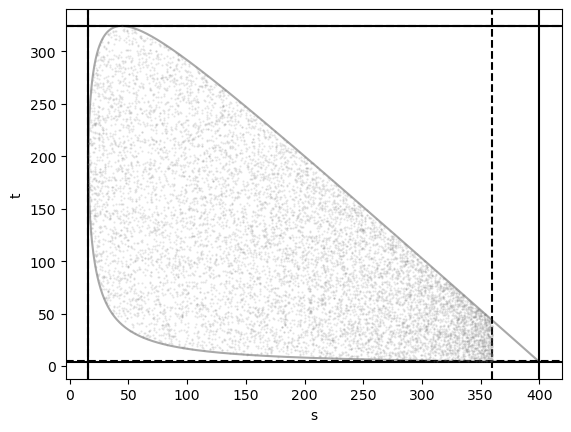

In [4]:
m_h = 20
m = 2
E_phot_min = 1 #GeV
s_min_fix = 4 * m ** 2 
s_max_fix = m_h ** 2 - 2 * m_h * E_phot_min
t_min_fix = t_min(s_max_fix, m)
t_max_fix = (m_h - m) ** 2

ss = []
ts = []
for i in range(0, 10000):
    x_0 = rand.random()
    x_1 = rand.random()
    s_subs = s_min_fix + (s_max_fix - s_min_fix) * x_1
    t_subs = t_min(s_subs, m) + (t_max(s_subs, m) - t_min(s_subs, m)) * x_0
    ts += [t_subs]
    ss += [s_subs] 
       
tp = np.linspace(m ** 2, (m_h - m) ** 2, 1000)
sp = np.linspace(4 * m ** 2, m_h ** 2, 1000)
plt.plot(sp, t_max(sp, m), color = 'darkgray')
plt.plot(sp, t_min(sp, m), color = 'darkgray')

plt.axhline(t_min_fix, color = 'black', linestyle = 'dashed')
plt.axhline(t_max_fix, color = 'black', linestyle = 'dashed')
plt.axvline(s_min_fix, color = 'black', linestyle = 'dashed')
plt.axvline(s_max_fix, color = 'black', linestyle = 'dashed')
plt.axhline(m ** 2, color = 'black')
plt.axhline((m_h - m) ** 2, color = 'black')
plt.axvline(4 * m ** 2, color = 'black')
plt.axvline(m_h ** 2, color = 'black')
#plt.xscale('log')
#plt.yscale('log')
plt.xlabel('s')
plt.ylabel('t')
plt.plot(ss, ts, marker = '.', markersize = 1, ls = 'None', alpha = 0.2, color = 'gray')
#plt.legend()
plt.show()

In [79]:
m = m_m
E_phot_min = 5 #GeV
s_min_fix = 4 * m ** 2 
s_max_fix = m_h ** 2 - 2 * m_h * E_phot_min
t_min_fix = t_min(s_max_fix, m)
t_max_fix = (m_h - m) ** 2
print(s_max_fix)

14399.009999999998


In [2]:
m = m_m
E_phot_min = 5 #GeV
s_min_fix = 4 * m ** 2 
s_max_fix = m_h ** 2 - 2 * m_h * E_phot_min
t_min_fix = t_min(s_max_fix, m)
t_max_fix = (m_h - m) ** 2
nitns = 40
nevals = 10 ** 4
bins = 100

def total_s4(x):
    s_subs = s_min_fix + (s_max_fix - s_min_fix) * x[1] #primed
    t_subs = t_min(s_subs, m_m) + (t_max(s_subs, m_m) - t_min(s_subs, m_m)) * x[0] #unprimed
    u = m_h ** 2 + 2 * m_m ** 2 - s_subs - t_subs
    
    dI_4 = np.zeros(bins, dtype=float) 
    dr = (s_max_fix - s_min_fix) / len(dI_4)
    dI_4_t = np.zeros(bins, dtype=float) 
    dr_t = (t_max_fix - t_min_fix) / len(dI_4)
    dI_4cos = np.zeros(bins, dtype=float) 
    dr_cos = 2 / len(dI_4cos) 
    dI_4cos_alt = np.zeros(bins, dtype=float)
    dr_cos_alt = 2 / len(dI_4cos_alt)
    
    I_4 = (s_max_fix - s_min_fix) * (t_max(s_subs, m_m) - t_min(s_subs, m_m)) * diff_decay2(s_subs, t_subs, m, C_eB, C_eW, C_AA, C_AZ, C_eH, sin, cos)[0]
    
    j = int((s_subs - s_min_fix) / dr)
    j_t = int((t_subs - t_min_fix) / dr_t)
    
    dI_4[j] = I_4
    dI_4_t[j_t] = I_4
    
    j_cos = int((cos_lk(m_m, E_l(m_m, u), E_phot(m_m, s_subs), t_subs) + 1) / dr_cos) 
    j_cos_alt = int((cos_ll(m_m, E_l(m_m, u), E_lbar(m_m, t_subs), s_subs) + 1) / dr_cos_alt)
    
    dI_4cos[j_cos] = I_4
    dI_4cos_alt[j_cos_alt] = I_4
   
    return dict(I_4=I_4, dI_4=dI_4, dI_4_t=dI_4_t, dI_4cos=dI_4cos, dI_4cos_alt=dI_4cos_alt)

total_decay_integ = vegas.Integrator([[0, 1], [0, 1]])
total_decay_integ(total_s4, nitn = nitns, neval = nevals)
total_rate4 = total_decay_integ(total_s4, nitn = nitns, neval = nevals)
print(total_rate4.summary())
print('Sum(dI/I) =', sum(total_rate4['dI_4']) / total_rate4['I_4']) #should be 1

computed_4 = total_rate4['I_4'].mean
error_4 = total_rate4['I_4'].sdev
print('Vegas Cross-Section = '+str(computed_4)+' +/ '+str(error_4)+'')

itn   integral        wgt average      chi2/dof        Q
--------------------------------------------------------
  1   1.00311(20)e-07 1.00311(20)e-07      0.00     1.00
  2   1.00292(21)e-07 1.00295(14)e-07      1.09     0.10
  3   1.00300(20)e-07 1.00288(11)e-07      1.17     0.00
  4   1.00303(20)e-07 1.002879(98)e-07     1.24     0.00
  5   1.00295(22)e-07 1.002802(88)e-07     1.34     0.00
  6   1.00294(20)e-07 1.002798(81)e-07     1.32     0.00
  7   1.00291(20)e-07 1.002800(74)e-07     1.32     0.00
  8   1.00305(20)e-07 1.002828(69)e-07     1.32     0.00
  9   1.00286(21)e-07 1.002816(65)e-07     1.31     0.00
 10   1.00297(20)e-07 1.002812(62)e-07     1.33     0.00
 11   1.00284(20)e-07 1.002799(59)e-07     1.33     0.00
 12   1.00268(20)e-07 1.002769(56)e-07     1.32     0.00
 13   1.00272(21)e-07 1.002741(54)e-07     1.32     0.00
 14   1.00273(22)e-07 1.002728(52)e-07     1.34     0.00
 15   1.00304(20)e-07 1.002742(50)e-07     1.34     0.00
 16   1.00266(21)e-07 1.002724(

In [3]:
m = m_m
E_phot_min = 5 #GeV
s_min_fix = 4 * m ** 2 
s_max_fix = m_h ** 2 - 2 * m_h * E_phot_min
t_min_fix = t_min(s_max_fix, m)
t_max_fix = (m_h - m) ** 2
nitns = 40
nevals = 10 ** 4
bins = 100

def total_s6_1(x):
    s_subs = s_min_fix + (s_max_fix - s_min_fix) * x[1] #primed
    t_subs = t_min(s_subs, m_m) + (t_max(s_subs, m_m) - t_min(s_subs, m_m)) * x[0] #unprimed
    u = m_h ** 2 + 2 * m_m ** 2 - s_subs - t_subs
    
    dI_6_1 = np.zeros(bins, dtype=float)
    dr = (s_max_fix - s_min_fix) / len(dI_6_1) 
    dI_6_1t = np.zeros(bins, dtype=float) 
    dr_t = (t_max_fix - t_min_fix) / len(dI_6_1t) 
    dI_6_1cos = np.zeros(bins, dtype=float) 
    dr_cos = 2 / len(dI_6_1cos) 
    dI_6_1cos_alt = np.zeros(bins, dtype=float)
    dr_cos_alt = 2 / len(dI_6_1cos_alt)
    
    I_6_1 = (s_max_fix - s_min_fix) * (t_max(s_subs, m_m) - t_min(s_subs, m_m)) * (diff_decay2(s_subs, t_subs, m, C_eB, C_eW, C_AA, C_AZ, C_eH, sin, cos)[1])
    j = int((s_subs - s_min_fix) / dr)
    j_t = int((t_subs - t_min_fix) / dr_t)
    
    dI_6_1[j] = I_6_1
    dI_6_1t[j_t] = I_6_1
    
    j_cos = int((cos_lk(m_m, E_l(m_m, u), E_phot(m_m, s_subs), t_subs) + 1) / dr_cos) 
    j_cos_alt = int((cos_ll(m_m, E_l(m_m, u), E_lbar(m_m, t_subs), s_subs) + 1) / dr_cos_alt)
    
    dI_6_1cos[j_cos] = I_6_1
    dI_6_1cos_alt[j_cos_alt] = I_6_1
   
    return dict(I_6_1=I_6_1, dI_6_1=dI_6_1, dI_6_1t=dI_6_1t, dI_6_1cos=dI_6_1cos, dI_6_1cos_alt=dI_6_1cos_alt)

total_decay_integ = vegas.Integrator([[0, 1], [0, 1]])
total_decay_integ(total_s6_1, nitn=nitns, neval=nevals)
total_rate6_1 = total_decay_integ(total_s6_1, nitn = nitns, neval = nevals)
print(total_rate6_1.summary())
print('Sum(dI/I) =', sum(total_rate6_1['dI_6_1']) / total_rate6_1['I_6_1'])

computed_6_1 = total_rate6_1['I_6_1'].mean
error_6_1 = total_rate6_1['I_6_1'].sdev
print('Vegas Cross-Section = '+str(computed_6_1)+' +/ '+str(error_6_1)+'')

itn   integral        wgt average     chi2/dof        Q
-------------------------------------------------------
  1   2.6175(23)e-11  2.6175(23)e-11      0.00     1.00
  2   2.6147(22)e-11  2.6148(15)e-11      0.95     0.75
  3   2.6129(21)e-11  2.6138(12)e-11      1.07     0.09
  4   2.6139(20)e-11  2.6133(10)e-11      1.12     0.00
  5   2.6106(21)e-11  2.61234(92)e-11     1.16     0.00
  6   2.6129(20)e-11  2.61210(83)e-11     1.17     0.00
  7   2.6139(20)e-11  2.61219(76)e-11     1.17     0.00
  8   2.6132(20)e-11  2.61212(70)e-11     1.17     0.00
  9   2.6120(19)e-11  2.61190(65)e-11     1.16     0.00
 10   2.6131(19)e-11  2.61188(61)e-11     1.16     0.00
 11   2.6185(18)e-11  2.61231(58)e-11     1.17     0.00
 12   2.6145(18)e-11  2.61244(55)e-11     1.17     0.00
 13   2.6130(18)e-11  2.61239(52)e-11     1.17     0.00
 14   2.6128(17)e-11  2.61232(50)e-11     1.18     0.00
 15   2.6144(18)e-11  2.61233(47)e-11     1.19     0.00
 16   2.6176(17)e-11  2.61267(46)e-11     1.18  

In [4]:
m = m_m
E_phot_min = 5 #GeV
s_min_fix = 4 * m ** 2 
s_max_fix = m_h ** 2 - 2 * m_h * E_phot_min
t_min_fix = t_min(s_max_fix, m)
t_max_fix = (m_h - m) ** 2
nitns = 40
nevals = 10 ** 4
bins = 100

def total_s6_2(x):
    s_subs = s_min_fix + (s_max_fix - s_min_fix) * x[1] #primed
    t_subs = t_min(s_subs, m_m) + (t_max(s_subs, m_m) - t_min(s_subs, m_m)) * x[0] #unprimed
    u = m_h ** 2 + 2 * m_m ** 2 - s_subs - t_subs
    
    dI_6_2 = np.zeros(bins, dtype=float)
    dr = (s_max_fix - s_min_fix) / len(dI_6_2) 
    dI_6_2t = np.zeros(bins, dtype=float) 
    dr_t = (t_max_fix - t_min_fix) / len(dI_6_2t) 
    dI_6_2cos = np.zeros(bins, dtype=float) 
    dr_cos = 2 / len(dI_6_2cos) 
    dI_6_2cos_alt = np.zeros(bins, dtype=float)
    dr_cos_alt = 2 / len(dI_6_2cos_alt)
    #print(s_subs, t_subs)
    I_6_2 = (s_max_fix - s_min_fix) * (t_max(s_subs, m_m) - t_min(s_subs, m_m)) * (diff_decay2(s_subs, t_subs, m, C_eB, C_eW, C_AA, C_AZ, C_eH, sin, cos)[2])
    
    j = int((s_subs - s_min_fix) / dr)
    j_t = int((t_subs - t_min_fix) / dr_t)
    
    dI_6_2[j] = I_6_2
    dI_6_2t[j_t] = I_6_2
    
    j_cos = int((cos_lk(m_m, E_l(m_m, u), E_phot(m_m, s_subs), t_subs) + 1) / dr_cos) 
    j_cos_alt = int((cos_ll(m_m, E_l(m_m, u), E_lbar(m_m, t_subs), s_subs) + 1) / dr_cos_alt)
    
    dI_6_2cos[j_cos] = I_6_2
    dI_6_2cos_alt[j_cos_alt] = I_6_2
   
    return dict(I_6_2=I_6_2, dI_6_2=dI_6_2, dI_6_2t=dI_6_2t, dI_6_2cos=dI_6_2cos, dI_6_2cos_alt=dI_6_2cos_alt)

total_decay_integ = vegas.Integrator([[0, 1], [0, 1]])
total_decay_integ(total_s6_2, nitn=nitns, neval=nevals)
total_rate6_2 = total_decay_integ(total_s6_2, nitn = nitns, neval = nevals, adapt = False)
print(total_rate6_2.summary())
print('Sum(dI/I) =', sum(total_rate6_2['dI_6_2']) / total_rate6_2['I_6_2']) #should be 1

computed_6_2 = total_rate6_2['I_6_2'].mean
error_6_2 = total_rate6_2['I_6_2'].sdev
print('Vegas Cross-Section = '+str(computed_6_2)+' +/ '+str(error_6_2)+'')

itn   integral        average          chi2/dof        Q
--------------------------------------------------------
  1   -2.7431(34)e-14 -2.7431(34)e-14      0.00     1.00
  2   -2.7461(35)e-14 -2.7446(24)e-14      1.11     0.06
  3   -2.7435(34)e-14 -2.7442(20)e-14      1.06     0.13
  4   -2.7411(34)e-14 -2.7434(17)e-14      1.05     0.12
  5   -2.7475(34)e-14 -2.7443(15)e-14      1.08     0.02
  6   -2.7394(33)e-14 -2.7434(14)e-14      1.06     0.04
  7   -2.7430(34)e-14 -2.7434(13)e-14      1.02     0.23
  8   -2.7393(34)e-14 -2.7429(12)e-14      1.02     0.27
  9   -2.7455(34)e-14 -2.7432(11)e-14      1.02     0.18
 10   -2.7375(34)e-14 -2.7426(11)e-14      1.02     0.23
 11   -2.7451(34)e-14 -2.7428(10)e-14      1.02     0.23
 12   -2.7406(34)e-14 -2.74262(98)e-14     1.01     0.29
 13   -2.7363(34)e-14 -2.74214(94)e-14     1.02     0.22
 14   -2.7408(34)e-14 -2.74205(91)e-14     1.02     0.19
 15   -2.7418(34)e-14 -2.74203(88)e-14     1.03     0.06
 16   -2.7416(34)e-14 -2.74200(

In [5]:
m = m_m
E_phot_min = 5 #GeV
s_min_fix = 4 * m ** 2 
s_max_fix = m_h ** 2 - 2 * m_h * E_phot_min
t_min_fix = t_min(s_max_fix, m)
t_max_fix = (m_h - m) ** 2
nitns = 40
nevals = 10 ** 4
bins = 100

def total_s6_3(x):
    s_subs = s_min_fix + (s_max_fix - s_min_fix) * x[1] #primed
    t_subs = t_min(s_subs, m_m) + (t_max(s_subs, m_m) - t_min(s_subs, m_m)) * x[0] #unprimed
    u = m_h ** 2 + 2 * m_m ** 2 - s_subs - t_subs
    
    dI_6_3 = np.zeros(bins, dtype=float)
    dr = (s_max_fix - s_min_fix) / len(dI_6_3) 
    dI_6_3t = np.zeros(bins, dtype=float) 
    dr_t = (t_max_fix - t_min_fix) / len(dI_6_3t) 
    dI_6_3cos = np.zeros(bins, dtype=float) 
    dr_cos = 2 / len(dI_6_3cos) 
    dI_6_3cos_alt = np.zeros(bins, dtype=float)
    dr_cos_alt = 2 / len(dI_6_3cos_alt)
    
    I_6_3 = (s_max_fix - s_min_fix) * (t_max(s_subs, m_m) - t_min(s_subs, m_m)) * (diff_decay2(s_subs, t_subs, m, C_eB, C_eW, C_AA, C_AZ, C_eH, sin, cos)[3])
    j = int((s_subs - s_min_fix) / dr)
    j_t = int((t_subs - t_min_fix) / dr_t)
    
    dI_6_3[j] = I_6_3
    dI_6_3t[j_t] = I_6_3
    
    j_cos = int((cos_lk(m_m, E_l(m_m, u), E_phot(m_m, s_subs), t_subs) + 1) / dr_cos) 
    j_cos_alt = int((cos_ll(m_m, E_l(m_m, u), E_lbar(m_m, t_subs), s_subs) + 1) / dr_cos_alt)
    
    dI_6_3cos[j_cos] = I_6_3
    dI_6_3cos_alt[j_cos_alt] = I_6_3
   
    return dict(I_6_3=I_6_3, dI_6_3=dI_6_3, dI_6_3t=dI_6_3t, dI_6_3cos=dI_6_3cos, dI_6_3cos_alt=dI_6_3cos_alt)

total_decay_integ = vegas.Integrator([[0, 1], [0, 1]])
total_decay_integ(total_s6_3, nitn=nitns, neval=nevals)
total_rate6_3 = total_decay_integ(total_s6_3, nitn = nitns, neval = nevals) #, adapt = False)
print(total_rate6_3.summary())
print('Sum(dI/I) =', sum(total_rate6_3['dI_6_3']) / total_rate6_3['I_6_3']) #should be 1

computed_6_3 = total_rate6_3['I_6_3'].mean
error_6_3 = total_rate6_3['I_6_3'].sdev
print('Vegas Cross-Section = '+str(computed_6_3)+' +/ '+str(error_6_3)+'')

itn   integral         wgt average       chi2/dof        Q
----------------------------------------------------------
  1   -2.23252(44)e-09 -2.23252(44)e-09      0.00     1.00
  2   -2.23173(47)e-09 -2.23209(31)e-09      0.99     0.56
  3   -2.23295(45)e-09 -2.23230(25)e-09      1.12     0.01
  4   -2.23149(48)e-09 -2.23208(22)e-09      1.16     0.00
  5   -2.23303(44)e-09 -2.23222(20)e-09      1.19     0.00
  6   -2.23186(44)e-09 -2.23208(18)e-09      1.18     0.00
  7   -2.23278(47)e-09 -2.23211(17)e-09      1.22     0.00
  8   -2.23312(44)e-09 -2.23218(15)e-09      1.23     0.00
  9   -2.23167(46)e-09 -2.23212(15)e-09      1.24     0.00
 10   -2.23185(49)e-09 -2.23202(14)e-09      1.25     0.00
 11   -2.23240(47)e-09 -2.23200(13)e-09      1.24     0.00
 12   -2.23266(47)e-09 -2.23196(13)e-09      1.28     0.00
 13   -2.23155(46)e-09 -2.23191(12)e-09      1.27     0.00
 14   -2.23227(47)e-09 -2.23191(12)e-09      1.27     0.00
 15   -2.23298(47)e-09 -2.23197(11)e-09      1.28     0.

In [6]:
m = m_m
E_phot_min = 5 #GeV
s_min_fix = 4 * m ** 2 
s_max_fix = m_h ** 2 - 2 * m_h * E_phot_min
t_min_fix = t_min(s_max_fix, m)
t_max_fix = (m_h - m) ** 2
nitns = 40
nevals = 10 ** 4
bins = 100

def total_s6_4(x):
    s_subs = s_min_fix + (s_max_fix - s_min_fix) * x[1] #primed
    t_subs = t_min(s_subs, m_m) + (t_max(s_subs, m_m) - t_min(s_subs, m_m)) * x[0] #unprimed
    u = m_h ** 2 + 2 * m_m ** 2 - s_subs - t_subs
    
    dI_6_4 = np.zeros(bins, dtype=float)
    dr = (s_max_fix - s_min_fix) / len(dI_6_4) 
    dI_6_4t = np.zeros(bins, dtype=float) 
    dr_t = (t_max_fix - t_min_fix) / len(dI_6_4t) 
    dI_6_4cos = np.zeros(bins, dtype=float) 
    dr_cos = 2 / len(dI_6_4cos) 
    dI_6_4cos_alt = np.zeros(bins, dtype=float)
    dr_cos_alt = 2 / len(dI_6_4cos_alt)
    
    I_6_4 = (s_max_fix - s_min_fix) * (t_max(s_subs, m_m) - t_min(s_subs, m_m)) * (diff_decay2(s_subs, t_subs, m, C_eB, C_eW, C_AA, C_AZ, C_eH, sin, cos)[4])
    j = int((s_subs - s_min_fix) / dr)
    j_t = int((t_subs - t_min_fix) / dr_t)
    
    dI_6_4[j] = I_6_4
    dI_6_4t[j_t] = I_6_4
    
    j_cos = int((cos_lk(m_m, E_l(m_m, u), E_phot(m_m, s_subs), t_subs) + 1) / dr_cos) 
    j_cos_alt = int((cos_ll(m_m, E_l(m_m, u), E_lbar(m_m, t_subs), s_subs) + 1) / dr_cos_alt)
    
    dI_6_4cos[j_cos] = I_6_4
    dI_6_4cos_alt[j_cos_alt] = I_6_4
   
    return dict(I_6_4=I_6_4, dI_6_4=dI_6_4, dI_6_4t=dI_6_4t, dI_6_4cos=dI_6_4cos, dI_6_4cos_alt=dI_6_4cos_alt)

total_decay_integ = vegas.Integrator([[0, 1], [0, 1]])
total_decay_integ(total_s6_4, nitn=nitns, neval=nevals)
total_rate6_4 = total_decay_integ(total_s6_4, nitn = nitns, neval = nevals) #, adapt = False)
print(total_rate6_4.summary())
print('Sum(dI/I) =', sum(total_rate6_4['dI_6_4']) / total_rate6_4['I_6_4']) #should be 1

computed_6_4 = total_rate6_4['I_6_4'].mean
error_6_4 = total_rate6_4['I_6_4'].sdev
print('Vegas Cross-Section = '+str(computed_6_4)+' +/ '+str(error_6_4)+'')

itn   integral         wgt average       chi2/dof        Q
----------------------------------------------------------
  1   -7.50691(25)e-12 -7.50691(25)e-12      0.00     1.00
  2   -7.50756(42)e-12 -7.50703(21)e-12      0.97     0.64
  3   -7.50719(49)e-12 -7.50704(19)e-12      0.99     0.54
  4   -7.50668(54)e-12 -7.50700(17)e-12      1.01     0.38
  5   -7.50704(77)e-12 -7.50700(17)e-12      1.02     0.31
  6   -7.50684(54)e-12 -7.50702(16)e-12      1.04     0.12
  7   -7.50682(55)e-12 -7.50706(15)e-12      1.07     0.01
  8   -7.50705(61)e-12 -7.50703(15)e-12      1.10     0.00
  9   -7.50690(68)e-12 -7.50697(14)e-12      1.12     0.00
 10   -7.50522(74)e-12 -7.50688(14)e-12      1.15     0.00
 11   -7.5082(11)e-12  -7.50685(13)e-12      1.17     0.00
 12   -7.5075(11)e-12  -7.50684(13)e-12      1.21     0.00
 13   -7.5058(11)e-12  -7.50682(13)e-12      1.23     0.00
 14   -7.5064(11)e-12  -7.50679(13)e-12      1.28     0.00
 15   -7.5077(13)e-12  -7.50680(13)e-12      1.28     0.

In [7]:
m = m_m
E_phot_min = 5 #GeV
s_min_fix = 4 * m ** 2 
s_max_fix = m_h ** 2 - 2 * m_h * E_phot_min
t_min_fix = t_min(s_max_fix, m)
t_max_fix = (m_h - m) ** 2
nitns = 40
nevals = 10 ** 4
bins = 100

def total_s8_5(x):
    s_subs = s_min_fix + (s_max_fix - s_min_fix) * x[1] #primed
    t_subs = t_min(s_subs, m_m) + (t_max(s_subs, m_m) - t_min(s_subs, m_m)) * x[0] #unprimed
    u = m_h ** 2 + 2 * m_m ** 2 - s_subs - t_subs
    
    dI_8_5 = np.zeros(bins, dtype=float)
    dr = (s_max_fix - s_min_fix) / len(dI_8_5) 
    dI_8_5t = np.zeros(bins, dtype=float) 
    dr_t = (t_max_fix - t_min_fix) / len(dI_8_5t) 
    dI_8_5cos = np.zeros(bins, dtype=float) 
    dr_cos = 2 / len(dI_8_5cos) 
    dI_8_5cos_alt = np.zeros(bins, dtype=float)
    dr_cos_alt = 2 / len(dI_8_5cos_alt)
    
    I_8_5 = (s_max_fix - s_min_fix) * (t_max(s_subs, m_m) - t_min(s_subs, m_m)) * (diff_decay2(s_subs, t_subs, m, C_eB, C_eW, C_AA, C_AZ, C_eH, sin, cos)[5])
    j = int((s_subs - s_min_fix) / dr)
    j_t = int((t_subs - t_min_fix) / dr_t)
    
    dI_8_5[j] = I_8_5
    dI_8_5t[j_t] = I_8_5
    
    j_cos = int((cos_lk(m_m, E_l(m_m, u), E_phot(m_m, s_subs), t_subs) + 1) / dr_cos) 
    j_cos_alt = int((cos_ll(m_m, E_l(m_m, u), E_lbar(m_m, t_subs), s_subs) + 1) / dr_cos_alt)
    
    dI_8_5cos[j_cos] = I_8_5
    dI_8_5cos_alt[j_cos_alt] = I_8_5
   
    return dict(I_8_5=I_8_5, dI_8_5=dI_8_5, dI_8_5t=dI_8_5t, dI_8_5cos=dI_8_5cos, dI_8_5cos_alt=dI_8_5cos_alt)

total_decay_integ = vegas.Integrator([[0, 1], [0, 1]])
total_decay_integ(total_s8_5, nitn=nitns, neval=nevals)
total_rate8_5 = total_decay_integ(total_s8_5, nitn = nitns, neval = nevals) #, adapt = False)
print(total_rate8_5.summary())
print('Sum(dI/I) =', sum(total_rate8_5['dI_8_5']) / total_rate8_5['I_8_5']) #should be 1

computed_8_5 = total_rate8_5['I_8_5'].mean
error_8_5 = total_rate8_5['I_8_5'].sdev
print('Vegas Cross-Section = '+str(computed_8_5)+' +/ '+str(error_8_5)+'')

itn   integral        wgt average      chi2/dof        Q
--------------------------------------------------------
  1   2.85095(40)e-12 2.85095(40)e-12      0.00     1.00
  2   2.85047(45)e-12 2.85074(28)e-12      1.16     0.01
  3   2.85016(46)e-12 2.85074(23)e-12      1.18     0.00
  4   2.85166(43)e-12 2.85096(19)e-12      1.23     0.00
  5   2.85014(48)e-12 2.85093(17)e-12      1.29     0.00
  6   2.84962(52)e-12 2.85075(16)e-12      1.40     0.00
  7   2.85083(43)e-12 2.85078(14)e-12      1.45     0.00
  8   2.85120(47)e-12 2.85084(13)e-12      1.49     0.00
  9   2.84956(42)e-12 2.85073(13)e-12      1.50     0.00
 10   2.85195(43)e-12 2.85085(12)e-12      1.50     0.00
 11   2.85067(49)e-12 2.85085(11)e-12      1.49     0.00
 12   2.84963(47)e-12 2.85079(11)e-12      1.50     0.00
 13   2.85046(48)e-12 2.85075(10)e-12      1.52     0.00
 14   2.85057(46)e-12 2.85076(10)e-12      1.53     0.00
 15   2.85087(47)e-12 2.850769(97)e-12     1.52     0.00
 16   2.85062(49)e-12 2.850781(

In [8]:
m = m_m
E_phot_min = 5 #GeV
s_min_fix = 4 * m ** 2 
s_max_fix = m_h ** 2 - 2 * m_h * E_phot_min
t_min_fix = t_min(s_max_fix, m)
t_max_fix = (m_h - m) ** 2
nitns = 40
nevals = 10 ** 4
bins = 100

def total_s8_6(x):
    s_subs = s_min_fix + (s_max_fix - s_min_fix) * x[1] #primed
    t_subs = t_min(s_subs, m_m) + (t_max(s_subs, m_m) - t_min(s_subs, m_m)) * x[0] #unprimed
    u = m_h ** 2 + 2 * m_m ** 2 - s_subs - t_subs
    
    dI_8_6 = np.zeros(bins, dtype=float)
    dr = (s_max_fix - s_min_fix) / len(dI_8_6) 
    dI_8_6t = np.zeros(bins, dtype=float) 
    dr_t = (t_max_fix - t_min_fix) / len(dI_8_6t) 
    dI_8_6cos = np.zeros(bins, dtype=float) 
    dr_cos = 2 / len(dI_8_6cos) 
    dI_8_6cos_alt = np.zeros(bins, dtype=float)
    dr_cos_alt = 2 / len(dI_8_6cos_alt)
    
    I_8_6 = (s_max_fix - s_min_fix) * (t_max(s_subs, m_m) - t_min(s_subs, m_m)) * (diff_decay2(s_subs, t_subs, m, C_eB, C_eW, C_AA, C_AZ, C_eH, sin, cos)[6])
    j = int((s_subs - s_min_fix) / dr)
    j_t = int((t_subs - t_min_fix) / dr_t)
    
    dI_8_6[j] = I_8_6
    dI_8_6t[j_t] = I_8_6
    
    j_cos = int((cos_lk(m_m, E_l(m_m, u), E_phot(m_m, s_subs), t_subs) + 1) / dr_cos) 
    j_cos_alt = int((cos_ll(m_m, E_l(m_m, u), E_lbar(m_m, t_subs), s_subs) + 1) / dr_cos_alt)
    
    dI_8_6cos[j_cos] = I_8_6
    dI_8_6cos_alt[j_cos_alt] = I_8_6
   
    return dict(I_8_6=I_8_6, dI_8_6=dI_8_6, dI_8_6t=dI_8_6t, dI_8_6cos=dI_8_6cos, dI_8_6cos_alt=dI_8_6cos_alt)

total_decay_integ = vegas.Integrator([[0, 1], [0, 1]])
total_decay_integ(total_s8_6, nitn=nitns, neval=nevals)
total_rate8_6 = total_decay_integ(total_s8_6, nitn = nitns, neval = nevals) #, adapt = False)
print(total_rate8_6.summary())
print('Sum(dI/I) =', sum(total_rate8_6['dI_8_6']) / total_rate8_6['I_8_6']) #should be 1

computed_8_6 = total_rate8_6['I_8_6'].mean
error_8_6 = total_rate8_6['I_8_6'].sdev
print('Vegas Cross-Section = '+str(computed_8_6)+' +/ '+str(error_8_6)+'')

itn   integral        wgt average      chi2/dof        Q
--------------------------------------------------------
  1   3.08583(54)e-13 3.08583(54)e-13      0.00     1.00
  2   3.08483(54)e-13 3.08534(37)e-13      0.87     0.97
  3   3.08609(55)e-13 3.08559(29)e-13      0.91     0.97
  4   3.08530(51)e-13 3.08552(24)e-13      0.93     0.96
  5   3.08625(49)e-13 3.08575(20)e-13      0.97     0.78
  6   3.08626(55)e-13 3.08593(18)e-13      0.98     0.70
  7   3.08577(70)e-13 3.08590(17)e-13      1.00     0.52
  8   3.08552(52)e-13 3.08602(15)e-13      1.02     0.21
  9   3.08552(61)e-13 3.08600(14)e-13      1.05     0.02
 10   3.08628(54)e-13 3.08607(14)e-13      1.08     0.00
 11   3.08503(56)e-13 3.08605(13)e-13      1.06     0.00
 12   3.08526(55)e-13 3.08612(12)e-13      1.08     0.00
 13   3.08658(56)e-13 3.08619(12)e-13      1.08     0.00
 14   3.08596(55)e-13 3.08619(11)e-13      1.08     0.00
 15   3.08546(50)e-13 3.08615(11)e-13      1.09     0.00
 16   3.08535(66)e-13 3.08615(1

In [9]:
m = m_m
E_phot_min = 5 #GeV
s_min_fix = 4 * m ** 2 
s_max_fix = m_h ** 2 - 2 * m_h * E_phot_min
t_min_fix = t_min(s_max_fix, m)
t_max_fix = (m_h - m) ** 2
nitns = 50
nevals = 10 ** 4
bins = 100

def total_s8_7(x):
    s_subs = s_min_fix + (s_max_fix - s_min_fix) * x[1] #primed
    t_subs = t_min(s_subs, m_m) + (t_max(s_subs, m_m) - t_min(s_subs, m_m)) * x[0] #unprimed
    u = m_h ** 2 + 2 * m_m ** 2 - s_subs - t_subs
    
    dI_8_7 = np.zeros(bins, dtype=float)
    dr = (s_max_fix - s_min_fix) / len(dI_8_7) 
    dI_8_7t = np.zeros(bins, dtype=float) 
    dr_t = (t_max_fix - t_min_fix) / len(dI_8_7t) 
    dI_8_7cos = np.zeros(bins, dtype=float) 
    dr_cos = 2 / len(dI_8_7cos) 
    dI_8_7cos_alt = np.zeros(bins, dtype=float)
    dr_cos_alt = 2 / len(dI_8_7cos_alt)
    
    I_8_7 = (s_max_fix - s_min_fix) * (t_max(s_subs, m_m) - t_min(s_subs, m_m)) * (diff_decay2(s_subs, t_subs, m, C_eB, C_eW, C_AA, C_AZ, C_eH, sin, cos)[7])
    j = int((s_subs - s_min_fix) / dr)
    j_t = int((t_subs - t_min_fix) / dr_t)
    
    dI_8_7[j] = I_8_7
    dI_8_7t[j_t] = I_8_7
    
    j_cos = int((cos_lk(m_m, E_l(m_m, u), E_phot(m_m, s_subs), t_subs) + 1) / dr_cos) 
    j_cos_alt = int((cos_ll(m_m, E_l(m_m, u), E_lbar(m_m, t_subs), s_subs) + 1) / dr_cos_alt)
    
    dI_8_7cos[j_cos] = I_8_7
    dI_8_7cos_alt[j_cos_alt] = I_8_7
   
    return dict(I_8_7=I_8_7, dI_8_7=dI_8_7, dI_8_7t=dI_8_7t, dI_8_7cos=dI_8_7cos, dI_8_7cos_alt=dI_8_7cos_alt)

total_decay_integ = vegas.Integrator([[0, 1], [0, 1]])
total_decay_integ(total_s8_7, nitn=nitns, neval=nevals)
total_rate8_7 = total_decay_integ(total_s8_7, nitn = nitns, neval = nevals) #, adapt = False)
print(total_rate8_7.summary())
print('Sum(dI/I) =', sum(total_rate8_7['dI_8_7']) / total_rate8_7['I_8_7']) #should be 1

computed_8_7 = total_rate8_7['I_8_7'].mean
error_8_7 = total_rate8_7['I_8_7'].sdev
print('Vegas Cross-Section = '+str(computed_8_7)+' +/ '+str(error_8_7)+'')

itn   integral        wgt average      chi2/dof        Q
--------------------------------------------------------
  1   1.11521(23)e-11 1.11521(23)e-11      0.00     1.00
  2   1.11526(23)e-11 1.11518(16)e-11      1.00     0.48
  3   1.11493(23)e-11 1.11506(13)e-11      1.13     0.01
  4   1.11532(23)e-11 1.11508(11)e-11      1.21     0.00
  5   1.11502(24)e-11 1.115034(99)e-11     1.25     0.00
  6   1.11510(23)e-11 1.115008(90)e-11     1.23     0.00
  7   1.11508(23)e-11 1.114988(84)e-11     1.22     0.00
  8   1.11467(23)e-11 1.114921(78)e-11     1.24     0.00
  9   1.11469(23)e-11 1.114879(74)e-11     1.25     0.00
 10   1.11505(23)e-11 1.114872(70)e-11     1.27     0.00
 11   1.11452(24)e-11 1.114827(67)e-11     1.27     0.00
 12   1.11508(23)e-11 1.114841(64)e-11     1.27     0.00
 13   1.11497(23)e-11 1.114817(61)e-11     1.28     0.00
 14   1.11525(24)e-11 1.114843(59)e-11     1.28     0.00
 15   1.11502(23)e-11 1.114836(57)e-11     1.28     0.00
 16   1.11461(22)e-11 1.114810(

In [10]:
m = m_m
E_phot_min = 5 #GeV
s_min_fix = 4 * m ** 2 
s_max_fix = m_h ** 2 - 2 * m_h * E_phot_min
t_min_fix = t_min(s_max_fix, m)
t_max_fix = (m_h - m) ** 2
nitns = 40
nevals = 10 ** 4
bins = 100

def total_s8_8(x):
    s_subs = s_min_fix + (s_max_fix - s_min_fix) * x[1] #primed
    t_subs = t_min(s_subs, m_m) + (t_max(s_subs, m_m) - t_min(s_subs, m_m)) * x[0] #unprimed
    u = m_h ** 2 + 2 * m_m ** 2 - s_subs - t_subs
    
    dI_8_8 = np.zeros(bins, dtype=float)
    dr = (s_max_fix - s_min_fix) / len(dI_8_8) 
    dI_8_8t = np.zeros(bins, dtype=float) 
    dr_t = (t_max_fix - t_min_fix) / len(dI_8_8t) 
    dI_8_8cos = np.zeros(bins, dtype=float) 
    dr_cos = 2 / len(dI_8_8cos) 
    dI_8_8cos_alt = np.zeros(bins, dtype=float)
    dr_cos_alt = 2 / len(dI_8_8cos_alt)
    
    I_8_8 = (s_max_fix - s_min_fix) * (t_max(s_subs, m_m) - t_min(s_subs, m_m)) * (diff_decay2(s_subs, t_subs, m, C_eB, C_eW, C_AA, C_AZ, C_eH, sin, cos)[8])
    j = int((s_subs - s_min_fix) / dr)
    j_t = int((t_subs - t_min_fix) / dr_t)
    
    dI_8_8[j] = I_8_8
    dI_8_8t[j_t] = I_8_8
    
    j_cos = int((cos_lk(m_m, E_l(m_m, u), E_phot(m_m, s_subs), t_subs) + 1) / dr_cos) 
    j_cos_alt = int((cos_ll(m_m, E_l(m_m, u), E_lbar(m_m, t_subs), s_subs) + 1) / dr_cos_alt)
    
    dI_8_8cos[j_cos] = I_8_8
    dI_8_8cos_alt[j_cos_alt] = I_8_8
   
    return dict(I_8_8=I_8_8, dI_8_8=dI_8_8, dI_8_8t=dI_8_8t, dI_8_8cos=dI_8_8cos, dI_8_8cos_alt=dI_8_8cos_alt)

total_decay_integ = vegas.Integrator([[0, 1], [0, 1]])
total_decay_integ(total_s8_8, nitn=nitns, neval=nevals)
total_rate8_8 = total_decay_integ(total_s8_8, nitn = nitns, neval = nevals) #, adapt = False)
print(total_rate8_8.summary())
print('Sum(dI/I) =', sum(total_rate8_8['dI_8_8']) / total_rate8_8['I_8_8']) #should be 1

computed_8_8 = total_rate8_8['I_8_8'].mean
error_8_8 = total_rate8_8['I_8_8'].sdev
print('Vegas Cross-Section = '+str(computed_8_8)+' +/ '+str(error_8_8)+'')

itn   integral         wgt average      chi2/dof        Q
---------------------------------------------------------
  1   -1.37698(93)e-14 -1.37698(93)e-14     0.00     1.00
  2   -1.37398(96)e-14 -1.37547(66)e-14     1.19     0.01
  3   -1.37504(95)e-14 -1.37529(53)e-14     1.13     0.01
  4   -1.37478(95)e-14 -1.37512(46)e-14     1.24     0.00
  5   -1.37496(96)e-14 -1.37510(41)e-14     1.30     0.00
  6   -1.37570(98)e-14 -1.37513(38)e-14     1.29     0.00
  7   -1.37584(96)e-14 -1.37513(35)e-14     1.29     0.00
  8   -1.37473(95)e-14 -1.37504(32)e-14     1.30     0.00
  9   -1.37546(95)e-14 -1.37509(31)e-14     1.29     0.00
 10   -1.37633(97)e-14 -1.37512(29)e-14     1.33     0.00
 11   -1.37573(96)e-14 -1.37518(28)e-14     1.33     0.00
 12   -1.37498(95)e-14 -1.37514(26)e-14     1.34     0.00
 13   -1.37457(99)e-14 -1.37509(25)e-14     1.34     0.00
 14   -1.37503(95)e-14 -1.37509(25)e-14     1.35     0.00
 15   -1.37431(99)e-14 -1.37500(24)e-14     1.37     0.00
 16   -1.37676

In [11]:
m = m_m
E_phot_min = 5 #GeV
s_min_fix = 4 * m ** 2 
s_max_fix = m_h ** 2 - 2 * m_h * E_phot_min
t_min_fix = t_min(s_max_fix, m)
t_max_fix = (m_h - m) ** 2
nitns = 40
nevals = 10 ** 4
bins = 100

def total_s8_9(x):
    s_subs = s_min_fix + (s_max_fix - s_min_fix) * x[1] #primed
    t_subs = t_min(s_subs, m_m) + (t_max(s_subs, m_m) - t_min(s_subs, m_m)) * x[0] #unprimed
    u = m_h ** 2 + 2 * m_m ** 2 - s_subs - t_subs
    
    dI_8_9 = np.zeros(bins, dtype=float)
    dr = (s_max_fix - s_min_fix) / len(dI_8_9) 
    dI_8_9t = np.zeros(bins, dtype=float) 
    dr_t = (t_max_fix - t_min_fix) / len(dI_8_9t) 
    dI_8_9cos = np.zeros(bins, dtype=float) 
    dr_cos = 2 / len(dI_8_9cos) 
    dI_8_9cos_alt = np.zeros(bins, dtype=float)
    dr_cos_alt = 2 / len(dI_8_9cos_alt)
    
    I_8_9 = (s_max_fix - s_min_fix) * (t_max(s_subs, m_m) - t_min(s_subs, m_m)) * (diff_decay2(s_subs, t_subs, m, C_eB, C_eW, C_AA, C_AZ, C_eH, sin, cos)[9])
    j = int((s_subs - s_min_fix) / dr)
    j_t = int((t_subs - t_min_fix) / dr_t)
    
    dI_8_9[j] = I_8_9
    dI_8_9t[j_t] = I_8_9
    
    j_cos = int((cos_lk(m_m, E_l(m_m, u), E_phot(m_m, s_subs), t_subs) + 1) / dr_cos) 
    j_cos_alt = int((cos_ll(m_m, E_l(m_m, u), E_lbar(m_m, t_subs), s_subs) + 1) / dr_cos_alt)
    
    dI_8_9cos[j_cos] = I_8_9
    dI_8_9cos_alt[j_cos_alt] = I_8_9
   
    return dict(I_8_9=I_8_9, dI_8_9=dI_8_9, dI_8_9t=dI_8_9t, dI_8_9cos=dI_8_9cos, dI_8_9cos_alt=dI_8_9cos_alt)

total_decay_integ = vegas.Integrator([[0, 1], [0, 1]])
total_decay_integ(total_s8_9, nitn=nitns, neval=nevals)
total_rate8_9 = total_decay_integ(total_s8_9, nitn = nitns, neval = nevals) #, adapt = False)
print(total_rate8_9.summary())
print('Sum(dI/I) =', sum(total_rate8_9['dI_8_9']) / total_rate8_9['I_8_9']) #should be 1

computed_8_9 = total_rate8_9['I_8_9'].mean
error_8_9 = total_rate8_9['I_8_9'].sdev
print('Vegas Cross-Section = '+str(computed_8_9)+' +/ '+str(error_8_9)+'')

itn   integral        wgt average      chi2/dof        Q
--------------------------------------------------------
  1   2.15449(40)e-15 2.15449(40)e-15      0.00     1.00
  2   2.15458(42)e-15 2.15440(27)e-15      1.15     0.02
  3   2.15468(42)e-15 2.15462(22)e-15      1.13     0.01
  4   2.15489(42)e-15 2.15477(18)e-15      1.12     0.00
  5   2.15496(40)e-15 2.15479(16)e-15      1.13     0.00
  6   2.15557(42)e-15 2.15493(15)e-15      1.13     0.00
  7   2.15480(35)e-15 2.15493(13)e-15      1.16     0.00
  8   2.15427(43)e-15 2.15484(13)e-15      1.18     0.00
  9   2.15483(41)e-15 2.15479(12)e-15      1.20     0.00
 10   2.15415(45)e-15 2.15476(11)e-15      1.18     0.00
 11   2.15355(52)e-15 2.15469(11)e-15      1.19     0.00
 12   2.15480(43)e-15 2.15473(10)e-15      1.19     0.00
 13   2.15469(46)e-15 2.15472(10)e-15      1.20     0.00
 14   2.15417(50)e-15 2.154682(98)e-15     1.20     0.00
 15   2.15494(36)e-15 2.154725(93)e-15     1.20     0.00
 16   2.15482(44)e-15 2.154729(

In [12]:
m = m_m
E_phot_min = 5 #GeV
s_min_fix = 4 * m ** 2 
s_max_fix = m_h ** 2 - 2 * m_h * E_phot_min
t_min_fix = t_min(s_max_fix, m)
t_max_fix = (m_h - m) ** 2
nitns = 40
nevals = 10 ** 4
bins = 100

def total_s8_10(x):
    s_subs = s_min_fix + (s_max_fix - s_min_fix) * x[1] #primed
    t_subs = t_min(s_subs, m_m) + (t_max(s_subs, m_m) - t_min(s_subs, m_m)) * x[0] #unprimed
    u = m_h ** 2 + 2 * m_m ** 2 - s_subs - t_subs
    
    dI_8_10 = np.zeros(bins, dtype=float)
    dr = (s_max_fix - s_min_fix) / len(dI_8_10) 
    dI_8_10t = np.zeros(bins, dtype=float) 
    dr_t = (t_max_fix - t_min_fix) / len(dI_8_10t) 
    dI_8_10cos = np.zeros(bins, dtype=float) 
    dr_cos = 2 / len(dI_8_10cos) 
    dI_8_10cos_alt = np.zeros(bins, dtype=float)
    dr_cos_alt = 2 / len(dI_8_10cos_alt)
    
    I_8_10 = (s_max_fix - s_min_fix) * (t_max(s_subs, m_m) - t_min(s_subs, m_m)) * (diff_decay2(s_subs, t_subs, m, C_eB, C_eW, C_AA, C_AZ, C_eH, sin, cos)[10])
    j = int((s_subs - s_min_fix) / dr)
    j_t = int((t_subs - t_min_fix) / dr_t)
    
    dI_8_10[j] = I_8_10
    dI_8_10t[j_t] = I_8_10
    
    j_cos = int((cos_lk(m_m, E_l(m_m, u), E_phot(m_m, s_subs), t_subs) + 1) / dr_cos) 
    j_cos_alt = int((cos_ll(m_m, E_l(m_m, u), E_lbar(m_m, t_subs), s_subs) + 1) / dr_cos_alt)
    
    dI_8_10cos[j_cos] = I_8_10
    dI_8_10cos_alt[j_cos_alt] = I_8_10
   
    return dict(I_8_10=I_8_10, dI_8_10=dI_8_10, dI_8_10t=dI_8_10t, dI_8_10cos=dI_8_10cos, dI_8_10cos_alt=dI_8_10cos_alt)

total_decay_integ = vegas.Integrator([[0, 1], [0, 1]])
total_decay_integ(total_s8_10, nitn=nitns, neval=nevals)
total_rate8_10 = total_decay_integ(total_s8_10, nitn = nitns, neval = nevals) #, adapt = False)
print(total_rate8_10.summary())
print('Sum(dI/I) =', sum(total_rate8_10['dI_8_10']) / total_rate8_10['I_8_10']) #should be 1

computed_8_10 = total_rate8_10['I_8_10'].mean
error_8_10 = total_rate8_10['I_8_10'].sdev
print('Vegas Cross-Section = '+str(computed_8_10)+' +/ '+str(error_8_10)+'')

itn   integral        wgt average      chi2/dof        Q
--------------------------------------------------------
  1   7.49877(39)e-14 7.49877(39)e-14      0.00     1.00
  2   7.49836(30)e-14 7.49857(23)e-14      1.22     0.00
  3   7.49831(41)e-14 7.49852(20)e-14      1.23     0.00
  4   7.49794(33)e-14 7.49839(16)e-14      1.21     0.00
  5   7.49838(30)e-14 7.49837(14)e-14      1.24     0.00
  6   7.49885(52)e-14 7.49840(14)e-14      1.22     0.00
  7   7.49899(64)e-14 7.49845(13)e-14      1.24     0.00
  8   7.49803(71)e-14 7.49845(13)e-14      1.25     0.00
  9   7.49858(73)e-14 7.49845(13)e-14      1.26     0.00
 10   7.49828(87)e-14 7.49844(12)e-14      1.25     0.00
 11   7.49947(81)e-14 7.49847(12)e-14      1.29     0.00
 12   7.49772(75)e-14 7.49841(12)e-14      1.32     0.00
 13   7.49809(99)e-14 7.49832(12)e-14      1.35     0.00
 14   7.4971(11)e-14  7.49828(12)e-14      1.40     0.00
 15   7.4989(11)e-14  7.49826(12)e-14      1.40     0.00
 16   7.4987(10)e-14  7.49826(1

In [13]:
dI_cos_4 = []
dI_cos_6_1 = []
dI_cos_6_2 = []
dI_cos_6_3 = []
dI_cos_6_4 = []
dI_cos_8_5 = []
dI_cos_8_6 = []
dI_cos_8_7 = []
dI_cos_8_8 = []
dI_cos_8_9 = []
dI_cos_8_10 = []
dI_cos_4_errs = []
dI_cos_6_1_errs = []
dI_cos_6_2_errs = []
dI_cos_6_3_errs = []
dI_cos_6_4_errs = []
dI_cos_8_5_errs = []
dI_cos_8_6_errs = []
dI_cos_8_7_errs = []
dI_cos_8_8_errs = []
dI_cos_8_9_errs = []
dI_cos_8_10_errs = []

for i in range(0, bins):
    dI_cos_4 += [total_rate4['dI_4cos'][i].mean]
    dI_cos_6_1 += [total_rate6_1['dI_6_1cos'][i].mean]
    dI_cos_6_2 += [total_rate6_2['dI_6_2cos'][i].mean]
    dI_cos_6_3 += [total_rate6_3['dI_6_3cos'][i].mean]
    dI_cos_6_4 += [total_rate6_4['dI_6_4cos'][i].mean]
    dI_cos_8_5 += [total_rate8_5['dI_8_5cos'][i].mean]
    dI_cos_8_6 += [total_rate8_6['dI_8_6cos'][i].mean]
    dI_cos_8_7 += [total_rate8_7['dI_8_7cos'][i].mean]
    dI_cos_8_8 += [total_rate8_8['dI_8_8cos'][i].mean]
    dI_cos_8_9 += [total_rate8_9['dI_8_9cos'][i].mean]
    dI_cos_8_10 += [total_rate8_10['dI_8_10cos'][i].mean]
    dI_cos_4_errs += [total_rate4['dI_4cos'][i].sdev]
    dI_cos_6_1_errs += [total_rate6_1['dI_6_1cos'][i].sdev]
    dI_cos_6_2_errs += [total_rate6_2['dI_6_2cos'][i].sdev]
    dI_cos_6_3_errs += [total_rate6_3['dI_6_3cos'][i].sdev]
    dI_cos_6_4_errs += [total_rate6_4['dI_6_4cos'][i].sdev]
    dI_cos_8_5_errs += [total_rate8_5['dI_8_5cos'][i].sdev]
    dI_cos_8_6_errs += [total_rate8_6['dI_8_6cos'][i].sdev]
    dI_cos_8_7_errs += [total_rate8_7['dI_8_7cos'][i].sdev]
    dI_cos_8_8_errs += [total_rate8_8['dI_8_8cos'][i].sdev]
    dI_cos_8_9_errs += [total_rate8_9['dI_8_9cos'][i].sdev]
    dI_cos_8_10_errs += [total_rate8_10['dI_8_10cos'][i].sdev]
    
rick.dump([dI_cos_4,dI_cos_4_errs], open('I_cos4_1mas_sep1', 'wb'))
rick.dump([dI_cos_6_1,dI_cos_6_1_errs], open('I_cos6_1mas_sep1', 'wb'))
rick.dump([dI_cos_6_2,dI_cos_6_2_errs], open('I_cos6_2mas_sep1', 'wb'))
rick.dump([dI_cos_6_3,dI_cos_6_3_errs], open('I_cos6_3mas_sep1', 'wb'))
rick.dump([dI_cos_6_4,dI_cos_6_4_errs], open('I_cos6_4mas_sep1', 'wb'))
rick.dump([dI_cos_8_5,dI_cos_8_5_errs], open('I_cos8_5mas_sep1', 'wb'))
rick.dump([dI_cos_8_6,dI_cos_8_6_errs], open('I_cos8_6mas_sep1', 'wb'))
rick.dump([dI_cos_8_7,dI_cos_8_7_errs], open('I_cos8_7mas_sep1', 'wb'))
rick.dump([dI_cos_8_8,dI_cos_8_8_errs], open('I_cos8_8mas_sep1', 'wb'))
rick.dump([dI_cos_8_9,dI_cos_8_9_errs], open('I_cos8_9mas_sep1', 'wb'))
rick.dump([dI_cos_8_10,dI_cos_8_10_errs], open('I_cos8_10mas_sep1', 'wb'))

In [14]:
dI_cos_alt_4 = []
dI_cos_alt_6_1 = []
dI_cos_alt_6_2 = []
dI_cos_alt_6_3 = []
dI_cos_alt_6_4 = []
dI_cos_alt_8_5 = []
dI_cos_alt_8_6 = []
dI_cos_alt_8_7 = []
dI_cos_alt_8_8 = []
dI_cos_alt_8_9 = []
dI_cos_alt_8_10 = []
dI_cos_alt_4_errs = []
dI_cos_alt_6_1_errs = []
dI_cos_alt_6_2_errs = []
dI_cos_alt_6_3_errs = []
dI_cos_alt_6_4_errs = []
dI_cos_alt_8_5_errs = []
dI_cos_alt_8_6_errs = []
dI_cos_alt_8_7_errs = []
dI_cos_alt_8_8_errs = []
dI_cos_alt_8_9_errs = []
dI_cos_alt_8_10_errs = []

for i in range(0, bins):
    dI_cos_alt_4 += [total_rate4['dI_4cos_alt'][i].mean]
    dI_cos_alt_6_1 += [total_rate6_1['dI_6_1cos_alt'][i].mean]
    dI_cos_alt_6_2 += [total_rate6_2['dI_6_2cos_alt'][i].mean]
    dI_cos_alt_6_3 += [total_rate6_3['dI_6_3cos_alt'][i].mean]
    dI_cos_alt_6_4 += [total_rate6_4['dI_6_4cos_alt'][i].mean]
    dI_cos_alt_8_5 += [total_rate8_5['dI_8_5cos_alt'][i].mean]
    dI_cos_alt_8_6 += [total_rate8_6['dI_8_6cos_alt'][i].mean]
    dI_cos_alt_8_7 += [total_rate8_7['dI_8_7cos_alt'][i].mean]
    dI_cos_alt_8_8 += [total_rate8_8['dI_8_8cos_alt'][i].mean]
    dI_cos_alt_8_9 += [total_rate8_9['dI_8_9cos_alt'][i].mean]
    dI_cos_alt_8_10 += [total_rate8_10['dI_8_10cos_alt'][i].mean]
    dI_cos_alt_4_errs += [total_rate4['dI_4cos_alt'][i].sdev]
    dI_cos_alt_6_1_errs += [total_rate6_1['dI_6_1cos_alt'][i].sdev]
    dI_cos_alt_6_2_errs += [total_rate6_2['dI_6_2cos_alt'][i].sdev]
    dI_cos_alt_6_3_errs += [total_rate6_3['dI_6_3cos_alt'][i].sdev]
    dI_cos_alt_6_4_errs += [total_rate6_4['dI_6_4cos_alt'][i].sdev]
    dI_cos_alt_8_5_errs += [total_rate8_5['dI_8_5cos_alt'][i].sdev]
    dI_cos_alt_8_6_errs += [total_rate8_6['dI_8_6cos_alt'][i].sdev]
    dI_cos_alt_8_7_errs += [total_rate8_7['dI_8_7cos_alt'][i].sdev]
    dI_cos_alt_8_8_errs += [total_rate8_8['dI_8_8cos_alt'][i].sdev]
    dI_cos_alt_8_9_errs += [total_rate8_9['dI_8_9cos_alt'][i].sdev]
    dI_cos_alt_8_10_errs += [total_rate8_10['dI_8_10cos_alt'][i].sdev]
    
rick.dump([dI_cos_alt_4,dI_cos_alt_4_errs], open('I_cos_alt4_1mas_sep1', 'wb'))
rick.dump([dI_cos_alt_6_1,dI_cos_alt_6_1_errs], open('I_cos_alt6_1mas_sep1', 'wb'))
rick.dump([dI_cos_alt_6_2,dI_cos_alt_6_2_errs], open('I_cos_alt6_2mas_sep1', 'wb'))
rick.dump([dI_cos_alt_6_3,dI_cos_alt_6_3_errs], open('I_cos_alt6_3mas_sep1', 'wb'))
rick.dump([dI_cos_alt_6_4,dI_cos_alt_6_4_errs], open('I_cos_alt6_4mas_sep1', 'wb'))
rick.dump([dI_cos_alt_8_5,dI_cos_alt_8_5_errs], open('I_cos_alt8_5mas_sep1', 'wb'))
rick.dump([dI_cos_alt_8_6,dI_cos_alt_8_6_errs], open('I_cos_alt8_6mas_sep1', 'wb'))
rick.dump([dI_cos_alt_8_7,dI_cos_alt_8_7_errs], open('I_cos_alt8_7mas_sep1', 'wb'))
rick.dump([dI_cos_alt_8_8,dI_cos_alt_8_8_errs], open('I_cos_alt8_8mas_sep1', 'wb'))
rick.dump([dI_cos_alt_8_9,dI_cos_alt_8_9_errs], open('I_cos_alt8_9mas_sep1', 'wb'))
rick.dump([dI_cos_alt_8_10,dI_cos_alt_8_10_errs], open('I_cos_alt8_10mas_sep1', 'wb'))

In [15]:
dI_4 = []
dI_6_1 = []
dI_6_2 = []
dI_6_3 = []
dI_6_4 = []
dI_8_5 = []
dI_8_6 = []
dI_8_7 = []
dI_8_8 = []
dI_8_9 = []
dI_8_10 = []
dI_4_errs = []
dI_6_1_errs = []
dI_6_2_errs = []
dI_6_3_errs = []
dI_6_4_errs = []
dI_8_5_errs = []
dI_8_6_errs = []
dI_8_7_errs = []
dI_8_8_errs = []
dI_8_9_errs = []
dI_8_10_errs = []

for i in range(0, bins):
    dI_4 += [total_rate4['dI_4'][i].mean]
    dI_6_1 += [total_rate6_1['dI_6_1'][i].mean]
    dI_6_2 += [total_rate6_2['dI_6_2'][i].mean]
    dI_6_3 += [total_rate6_3['dI_6_3'][i].mean]
    dI_6_4 += [total_rate6_4['dI_6_4'][i].mean]
    dI_8_5 += [total_rate8_5['dI_8_5'][i].mean]
    dI_8_6 += [total_rate8_6['dI_8_6'][i].mean]
    dI_8_7 += [total_rate8_7['dI_8_7'][i].mean]
    dI_8_8 += [total_rate8_8['dI_8_8'][i].mean]
    dI_8_9 += [total_rate8_9['dI_8_9'][i].mean]
    dI_8_10 += [total_rate8_10['dI_8_10'][i].mean]
    dI_4_errs += [total_rate4['dI_4'][i].sdev]
    dI_6_1_errs += [total_rate6_1['dI_6_1'][i].sdev]
    dI_6_2_errs += [total_rate6_2['dI_6_2'][i].sdev]
    dI_6_3_errs += [total_rate6_3['dI_6_3'][i].sdev]
    dI_6_4_errs += [total_rate6_4['dI_6_4'][i].sdev]
    dI_8_5_errs += [total_rate8_5['dI_8_5'][i].sdev]
    dI_8_6_errs += [total_rate8_6['dI_8_6'][i].sdev]
    dI_8_7_errs += [total_rate8_7['dI_8_7'][i].sdev]
    dI_8_8_errs += [total_rate8_8['dI_8_8'][i].sdev]
    dI_8_9_errs += [total_rate8_9['dI_8_9'][i].sdev]
    dI_8_10_errs += [total_rate8_10['dI_8_10'][i].sdev]
    
rick.dump([dI_4,dI_4_errs], open('I_4_1mas_sep1', 'wb'))
rick.dump([dI_6_1,dI_6_1_errs], open('I_6_1mas_sep1', 'wb'))
rick.dump([dI_6_2,dI_6_2_errs], open('I_6_2mas_sep1', 'wb'))
rick.dump([dI_6_3,dI_6_3_errs], open('I_6_3mas_sep1', 'wb'))
rick.dump([dI_6_4,dI_6_4_errs], open('I_6_4mas_sep1', 'wb'))
rick.dump([dI_8_5,dI_8_5_errs], open('I_8_5mas_sep1', 'wb'))
rick.dump([dI_8_6,dI_8_6_errs], open('I_8_6mas_sep1', 'wb'))
rick.dump([dI_8_7,dI_8_7_errs], open('I_8_7mas_sep1', 'wb'))
rick.dump([dI_8_8,dI_8_8_errs], open('I_8_8mas_sep1', 'wb'))
rick.dump([dI_8_9,dI_8_9_errs], open('I_8_9mas_sep1', 'wb'))
rick.dump([dI_8_10,dI_8_10_errs], open('I_8_10mas_sep1', 'wb'))

In [16]:
dI_4t = []
dI_6_1t = []
dI_6_2t = []
dI_6_3t = []
dI_6_4t = []
dI_8_5t = []
dI_8_6t = []
dI_8_7t = []
dI_8_8t = []
dI_8_9t = []
dI_8_10t = []
dI_4_errst = []
dI_6_1_errst = []
dI_6_2_errst = []
dI_6_3_errst = []
dI_6_4_errst = []
dI_8_5_errst = []
dI_8_6_errst = []
dI_8_7_errst = []
dI_8_8_errst = []
dI_8_9_errst = []
dI_8_10_errst = []

for i in range(0, bins):
    dI_4t += [total_rate4['dI_4_t'][i].mean]
    dI_6_1t += [total_rate6_1['dI_6_1t'][i].mean]
    dI_6_2t += [total_rate6_2['dI_6_2t'][i].mean]
    dI_6_3t += [total_rate6_3['dI_6_3t'][i].mean]
    dI_6_4t += [total_rate6_4['dI_6_4t'][i].mean]
    dI_8_5t += [total_rate8_5['dI_8_5t'][i].mean]
    dI_8_6t += [total_rate8_6['dI_8_6t'][i].mean]
    dI_8_7t += [total_rate8_7['dI_8_7t'][i].mean]
    dI_8_8t += [total_rate8_8['dI_8_8t'][i].mean]
    dI_8_9t += [total_rate8_9['dI_8_9t'][i].mean]
    dI_8_10t += [total_rate8_10['dI_8_10t'][i].mean]
    dI_4_errst += [total_rate4['dI_4_t'][i].sdev]
    dI_6_1_errst += [total_rate6_1['dI_6_1t'][i].sdev]
    dI_6_2_errst += [total_rate6_2['dI_6_2t'][i].sdev]
    dI_6_3_errst += [total_rate6_3['dI_6_3t'][i].sdev]
    dI_6_4_errst += [total_rate6_4['dI_6_4t'][i].sdev]
    dI_8_5_errst += [total_rate8_5['dI_8_5t'][i].sdev]
    dI_8_6_errst += [total_rate8_6['dI_8_6t'][i].sdev]
    dI_8_7_errst += [total_rate8_7['dI_8_7t'][i].sdev]
    dI_8_8_errst += [total_rate8_8['dI_8_8t'][i].sdev]
    dI_8_9_errst += [total_rate8_9['dI_8_9t'][i].sdev]
    dI_8_10_errst += [total_rate8_10['dI_8_10t'][i].sdev]
    
rick.dump([dI_4t,dI_4_errst], open('I_4_1tmas_sep1', 'wb'))
rick.dump([dI_6_1t,dI_6_1_errst], open('I_6_1tmas_sep1', 'wb'))
rick.dump([dI_6_2t,dI_6_2_errst], open('I_6_2tmas_sep1', 'wb'))
rick.dump([dI_6_3t,dI_6_3_errst], open('I_6_3tmas_sep1', 'wb'))
rick.dump([dI_6_4t,dI_6_4_errst], open('I_6_4tmas_sep1', 'wb'))
rick.dump([dI_8_5t,dI_8_5_errst], open('I_8_5tmas_sep1', 'wb'))
rick.dump([dI_8_6t,dI_8_6_errst], open('I_8_6tmas_sep1', 'wb'))
rick.dump([dI_8_7t,dI_8_7_errst], open('I_8_7tmas_sep1', 'wb'))
rick.dump([dI_8_8t,dI_8_8_errst], open('I_8_8tmas_sep1', 'wb'))
rick.dump([dI_8_9t,dI_8_9_errst], open('I_8_9tmas_sep1', 'wb'))
rick.dump([dI_8_10t,dI_8_10_errst], open('I_8_10tmas_sep1', 'wb'))

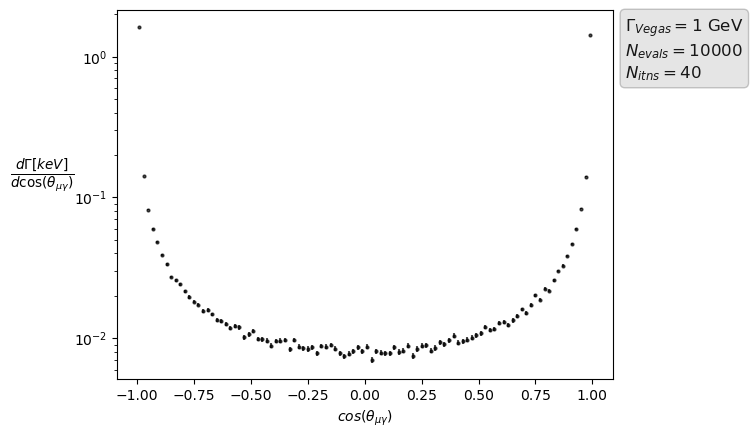

In [17]:
dI_cos = []
dI_cos_errs = []

cos_s = []
for i in range(0, bins):
    cos_s += [-1 + (i + 0.5) * 2 / bins]
    
for i in range(0, bins):
    dI_cos += [total_rate4['dI_4cos'][i].mean + total_rate6_1['dI_6_1cos'][i].mean + total_rate6_2['dI_6_2cos'][i].mean + total_rate6_3['dI_6_3cos'][i].mean + total_rate6_4['dI_6_4cos'][i].mean+ total_rate8_5['dI_8_5cos'][i].mean + total_rate8_6['dI_8_6cos'][i].mean + total_rate8_7['dI_8_7cos'][i].mean + total_rate8_8['dI_8_8cos'][i].mean+ total_rate8_9['dI_8_9cos'][i].mean + total_rate8_10['dI_8_10cos'][i].mean]
    dI_cos_errs += [total_rate4['dI_4cos'][i].sdev + total_rate6_1['dI_6_1cos'][i].sdev + total_rate6_2['dI_6_2cos'][i].sdev + total_rate6_3['dI_6_3cos'][i].sdev + total_rate6_4['dI_6_4cos'][i].sdev+ total_rate8_5['dI_8_5cos'][i].sdev + total_rate8_6['dI_8_6cos'][i].sdev + total_rate8_7['dI_8_7cos'][i].sdev + total_rate8_8['dI_8_8cos'][i].sdev+ total_rate8_9['dI_8_9cos'][i].sdev + total_rate8_10['dI_8_10cos'][i].sdev]
    
#rick.dump([dI_cos,dI_cos_errs], open('I_cos_mas_sep1', 'wb'))
    
norm = 2 / bins
keV = 10 ** 6

fig, ax = plt.subplots()

ax.errorbar(cos_s, keV * np.array(dI_cos) / norm, color = 'black', alpha = 0.7, 
            ls = 'None', markersize = 4, marker = '.', label = 'Vegas', yerr = keV * np.array(dI_cos_errs) / norm)

textstr = '\n'.join((
    r'$\Gamma_{Vegas}=$' +str(round(1, 11))+ ' GeV',
    r'$N_{evals}=$' +str(nevals)+ '',
    r'$N_{itns}=$' +str(nitns)+ ''))

props = dict(boxstyle='round', facecolor='gray', alpha=0.2)
ax.text(1.025, 0.98, textstr, transform=ax.transAxes, fontsize=12, alpha = 0.9,
        verticalalignment='top', bbox=props)

plt.yscale('log')
plt.ylabel(r'$\frac{d\Gamma[keV]}{d\cos(\theta_{\mu\gamma})}$', rotation = '0', fontsize = 14)
ax.yaxis.set_label_coords(-0.15, 0.5)
plt.xlabel(r'$cos(\theta_{\mu\gamma})$')
plt.show()

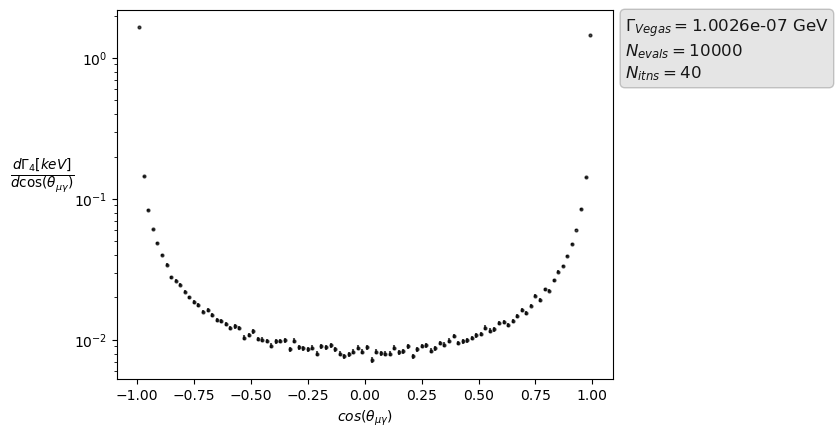

In [20]:
dI_cos4 = []
dI_cos4_errs = []

cos_s = []
for i in range(0, bins):
    cos_s += [-1 + (i + 0.5) * 2 / bins]
    
for i in range(0, bins):
    dI_cos4 += [total_rate4['dI_4cos'][i].mean]
    dI_cos4_errs += [total_rate4['dI_4cos'][i].sdev]
    
norm = 2 / bins
keV = 10 ** 6

fig, ax = plt.subplots()

ax.errorbar(cos_s, keV * np.array(dI_cos4) / norm, color = 'black', alpha = 0.7, 
            ls = 'None', markersize = 4, marker = '.', label = 'Vegas', yerr = keV * np.array(dI_cos4_errs) / norm)

textstr = '\n'.join((
    r'$\Gamma_{Vegas}=$' +str(round(computed_4, 11))+ ' GeV',
    r'$N_{evals}=$' +str(nevals)+ '',
    r'$N_{itns}=$' +str(nitns)+ ''))

props = dict(boxstyle='round', facecolor='gray', alpha=0.2)
ax.text(1.025, 0.98, textstr, transform=ax.transAxes, fontsize=12, alpha = 0.9,
        verticalalignment='top', bbox=props)

plt.yscale('log')
plt.ylabel(r'$\frac{d\Gamma_{4}[keV]}{d\cos(\theta_{\mu\gamma})}$', rotation = '0', fontsize = 14)
ax.yaxis.set_label_coords(-0.15, 0.5)
plt.xlabel(r'$cos(\theta_{\mu\gamma})$')
plt.show()

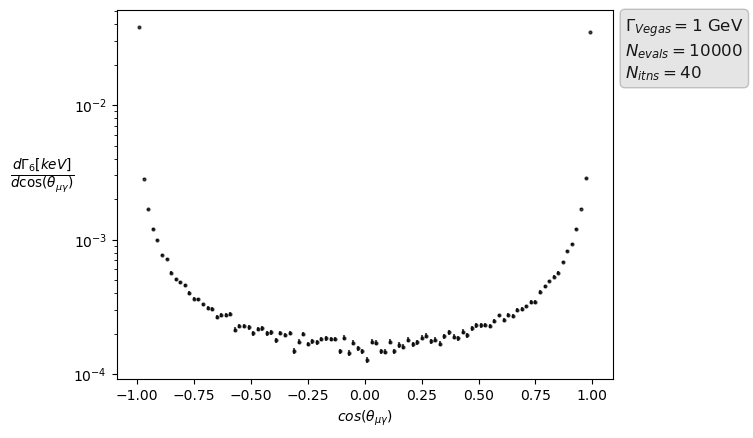

In [21]:
dI_cos6 = []
dI_cos6_errs = []

cos_s = []
for i in range(0, bins):
    cos_s += [-1 + (i + 0.5) * 2 / bins]
    
for i in range(0, bins):
    dI_cos6 += [total_rate6_1['dI_6_1cos'][i].mean + total_rate6_2['dI_6_2cos'][i].mean + total_rate6_3['dI_6_3cos'][i].mean + total_rate6_4['dI_6_4cos'][i].mean]
    dI_cos6_errs += [total_rate6_1['dI_6_1cos'][i].sdev + total_rate6_2['dI_6_2cos'][i].sdev + total_rate6_3['dI_6_3cos'][i].sdev + total_rate6_4['dI_6_4cos'][i].sdev]
        
norm = 2 / bins
keV = 10 ** 6

fig, ax = plt.subplots()

ax.errorbar(cos_s, -keV * np.array(dI_cos6) / norm, color = 'black', alpha = 0.7, 
            ls = 'None', markersize = 4, marker = '.', label = 'Vegas', yerr = keV * np.array(dI_cos6_errs) / norm)

textstr = '\n'.join((
    r'$\Gamma_{Vegas}=$' +str(round(1, 11))+ ' GeV',
    r'$N_{evals}=$' +str(nevals)+ '',
    r'$N_{itns}=$' +str(nitns)+ ''))

props = dict(boxstyle='round', facecolor='gray', alpha=0.2)
ax.text(1.025, 0.98, textstr, transform=ax.transAxes, fontsize=12, alpha = 0.9,
        verticalalignment='top', bbox=props)

plt.yscale('log')
#plt.ylim(-2.5 * 10**-6, 2 * 10**-5)
plt.ylabel(r'$\frac{d\Gamma_{6}[keV]}{d\cos(\theta_{\mu\gamma})}$', rotation = '0', fontsize = 14)
ax.yaxis.set_label_coords(-0.15, 0.5)
plt.xlabel(r'$cos(\theta_{\mu\gamma})$')
plt.show()

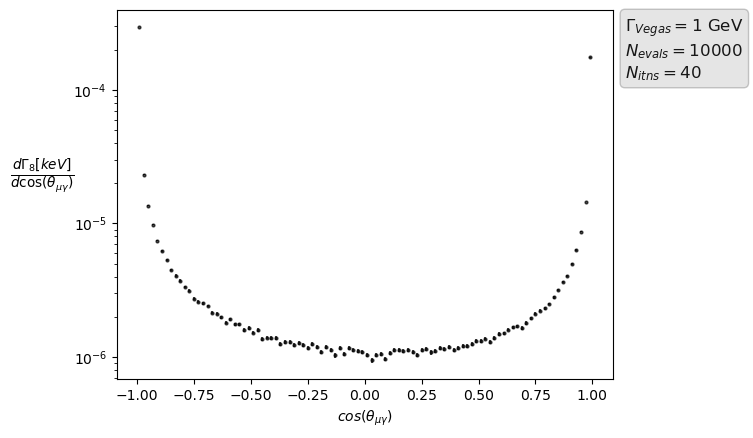

In [22]:
dI_cos8 = []
dI_cos8_errs = []

cos_s = []
for i in range(0, bins):
    cos_s += [-1 + (i + 0.5) * 2 / bins]
    
for i in range(0, bins):
    dI_cos8 += [total_rate8_5['dI_8_5cos'][i].mean + total_rate8_6['dI_8_6cos'][i].mean + total_rate8_7['dI_8_7cos'][i].mean + total_rate8_8['dI_8_8cos'][i].mean+ total_rate8_9['dI_8_9cos'][i].mean + total_rate8_10['dI_8_10cos'][i].mean]
    dI_cos8_errs += [total_rate8_5['dI_8_5cos'][i].sdev + total_rate8_6['dI_8_6cos'][i].sdev + total_rate8_7['dI_8_7cos'][i].sdev + total_rate8_8['dI_8_8cos'][i].sdev+ total_rate8_9['dI_8_9cos'][i].sdev + total_rate8_10['dI_8_10cos'][i].sdev]
    
norm = 2 / bins
keV = 10 ** 6

fig, ax = plt.subplots()

ax.errorbar(cos_s, keV * np.array(dI_cos8) / norm, color = 'black', alpha = 0.7, 
            ls = 'None', markersize = 4, marker = '.', label = 'Vegas', yerr = keV * np.array(dI_cos8_errs) / norm)

textstr = '\n'.join((
    r'$\Gamma_{Vegas}=$' +str(round(1, 11))+ ' GeV',
    r'$N_{evals}=$' +str(nevals)+ '',
    r'$N_{itns}=$' +str(nitns)+ ''))

props = dict(boxstyle='round', facecolor='gray', alpha=0.2)
ax.text(1.025, 0.98, textstr, transform=ax.transAxes, fontsize=12, alpha = 0.9,
        verticalalignment='top', bbox=props)

plt.yscale('log')
plt.ylabel(r'$\frac{d\Gamma_{8}[keV]}{d\cos(\theta_{\mu\gamma})}$', rotation = '0', fontsize = 14)
ax.yaxis.set_label_coords(-0.15, 0.5)
plt.xlabel(r'$cos(\theta_{\mu\gamma})$')
plt.show()

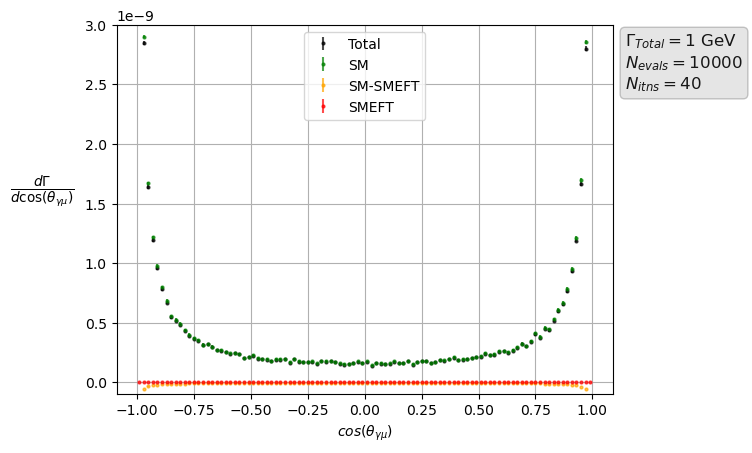

In [30]:
fig, ax = plt.subplots()

ax.errorbar(cos_s, np.array(dI_cos4)+np.array(dI_cos6)+np.array(dI_cos8), color = 'black', alpha = 0.7, 
            ls = 'None', markersize = 4, marker = '.', label = 'Total', yerr = np.array(dI_cos4_errs)+np.array(dI_cos6_errs)+np.array(dI_cos8_errs))
ax.errorbar(cos_s, np.array(dI_cos4), color = 'green', alpha = 0.7, 
            ls = 'None', markersize = 4, marker = '.', label = 'SM', yerr = np.array(dI_cos4_errs))
ax.errorbar(cos_s, np.array(dI_cos6), color = 'orange', alpha = 0.7, 
            ls = 'None', markersize = 4, marker = '.', label = 'SM-SMEFT', yerr = np.array(dI_cos6_errs))
ax.errorbar(cos_s, np.array(dI_cos8), color = 'red', alpha = 0.7, 
            ls = 'None', markersize = 4, marker = '.', label = 'SMEFT', yerr = np.array(dI_cos8_errs))

plt.grid()
textstr = '\n'.join((
    r'$\Gamma_{Total}=$' +str(round(1, 11))+ ' GeV',
    r'$N_{evals}=$' +str(nevals)+ '',
    r'$N_{itns}=$' +str(nitns)+ ''))

props = dict(boxstyle='round', facecolor='gray', alpha=0.2)
ax.text(1.025, 0.98, textstr, transform=ax.transAxes, fontsize=12, alpha = 0.9,
        verticalalignment='top', bbox=props)

#plt.yscale('log')

plt.ylabel(r'$\frac{d\Gamma}{d\cos(\theta_{\gamma\mu})}$', rotation = '0', fontsize = 14)
ax.yaxis.set_label_coords(-0.15, 0.5)
plt.xlabel(r'$cos(\theta_{\gamma\mu})$')
plt.ylim(-10**-10, 3 * 10**-9)
plt.legend()
#plt.xlim(0, 130)
plt.show()

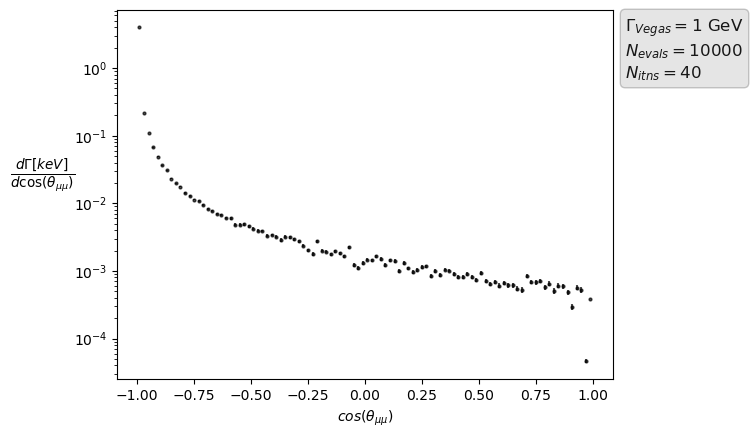

In [31]:
dI_cos_alt = []
dI_cos_alt_errs = []

cos_s = []
for i in range(0, bins):
    cos_s += [-1 + (i + 0.5) * 2 / bins]
    
for i in range(0, bins):
    dI_cos_alt += [total_rate4['dI_4cos_alt'][i].mean + total_rate6_1['dI_6_1cos_alt'][i].mean + total_rate6_2['dI_6_2cos_alt'][i].mean + total_rate6_3['dI_6_3cos_alt'][i].mean + total_rate6_4['dI_6_4cos_alt'][i].mean+ total_rate8_5['dI_8_5cos_alt'][i].mean + total_rate8_6['dI_8_6cos_alt'][i].mean + total_rate8_7['dI_8_7cos_alt'][i].mean + total_rate8_8['dI_8_8cos_alt'][i].mean+ total_rate8_9['dI_8_9cos_alt'][i].mean + total_rate8_10['dI_8_10cos_alt'][i].mean]
    dI_cos_alt_errs += [total_rate4['dI_4cos_alt'][i].sdev + total_rate6_1['dI_6_1cos_alt'][i].sdev + total_rate6_2['dI_6_2cos_alt'][i].sdev + total_rate6_3['dI_6_3cos_alt'][i].sdev + total_rate6_4['dI_6_4cos_alt'][i].sdev+ total_rate8_5['dI_8_5cos_alt'][i].sdev + total_rate8_6['dI_8_6cos_alt'][i].sdev + total_rate8_7['dI_8_7cos_alt'][i].sdev + total_rate8_8['dI_8_8cos_alt'][i].sdev+ total_rate8_9['dI_8_9cos_alt'][i].sdev + total_rate8_10['dI_8_10cos_alt'][i].sdev]
    
norm = 2 / bins
keV = 10 ** 6

fig, ax = plt.subplots()

ax.errorbar(cos_s, keV * np.array(dI_cos_alt) / norm, color = 'black', alpha = 0.7, 
            ls = 'None', markersize = 4, marker = '.', label = 'Vegas', yerr = keV * np.array(dI_cos_alt_errs) / norm)

textstr = '\n'.join((
    r'$\Gamma_{Vegas}=$' +str(round(1, 11))+ ' GeV',
    r'$N_{evals}=$' +str(nevals)+ '',
    r'$N_{itns}=$' +str(nitns)+ ''))

props = dict(boxstyle='round', facecolor='gray', alpha=0.2)
ax.text(1.025, 0.98, textstr, transform=ax.transAxes, fontsize=12, alpha = 0.9,
        verticalalignment='top', bbox=props)

plt.yscale('log')
plt.ylabel(r'$\frac{d\Gamma[keV]}{d\cos(\theta_{\mu\mu})}$', rotation = '0', fontsize = 14)
ax.yaxis.set_label_coords(-0.15, 0.5)
plt.xlabel(r'$cos(\theta_{\mu\mu})$')
plt.show()

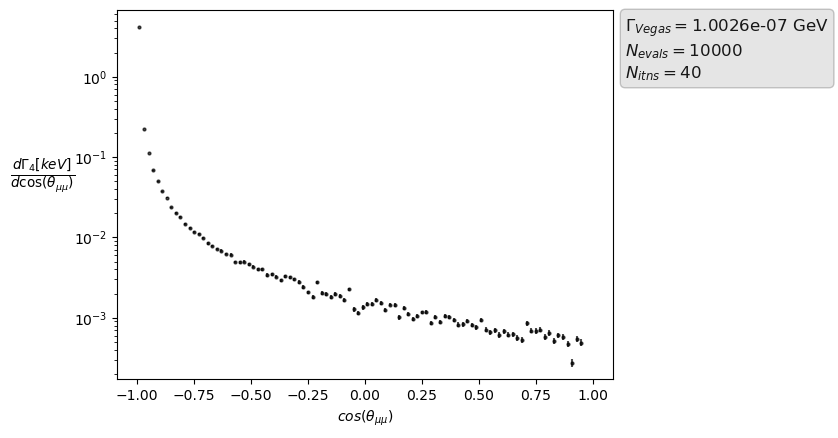

In [32]:
dI_cos4_alt = []
dI_cos4_alt_errs = []

cos_s = []
for i in range(0, bins):
    cos_s += [-1 + (i + 0.5) * 2 / bins]
    
for i in range(0, bins):
    dI_cos4_alt += [total_rate4['dI_4cos_alt'][i].mean]
    dI_cos4_alt_errs += [total_rate4['dI_4cos_alt'][i].sdev]
    
norm = 2 / bins
keV = 10 ** 6

fig, ax = plt.subplots()

ax.errorbar(cos_s, keV * np.array(dI_cos4_alt) / norm, color = 'black', alpha = 0.7, 
            ls = 'None', markersize = 4, marker = '.', label = 'Vegas', yerr = keV * np.array(dI_cos4_alt_errs) / norm)

textstr = '\n'.join((
    r'$\Gamma_{Vegas}=$' +str(round(computed_4, 11))+ ' GeV',
    r'$N_{evals}=$' +str(nevals)+ '',
    r'$N_{itns}=$' +str(nitns)+ ''))

props = dict(boxstyle='round', facecolor='gray', alpha=0.2)
ax.text(1.025, 0.98, textstr, transform=ax.transAxes, fontsize=12, alpha = 0.9,
        verticalalignment='top', bbox=props)

plt.yscale('log')
plt.ylabel(r'$\frac{d\Gamma_{4}[keV]}{d\cos(\theta_{\mu\mu})}$', rotation = '0', fontsize = 14)
ax.yaxis.set_label_coords(-0.15, 0.5)
plt.xlabel(r'$cos(\theta_{\mu\mu})$')
plt.show()

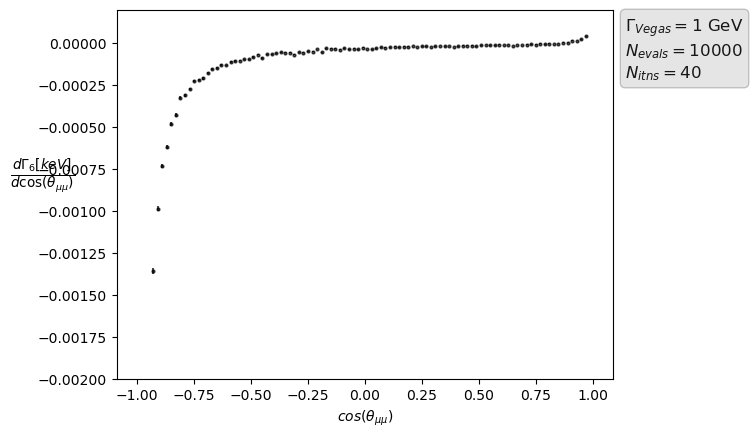

In [42]:
dI_cos6_alt = []
dI_cos6_alt_errs = []

cos_s = []
for i in range(0, bins):
    cos_s += [-1 + (i + 0.5) * 2 / bins]
    
for i in range(0, bins):
    dI_cos6_alt += [total_rate6_1['dI_6_1cos_alt'][i].mean + total_rate6_2['dI_6_2cos_alt'][i].mean + total_rate6_3['dI_6_3cos_alt'][i].mean + total_rate6_4['dI_6_4cos_alt'][i].mean]
    dI_cos6_alt_errs += [total_rate6_1['dI_6_1cos_alt'][i].sdev + total_rate6_2['dI_6_2cos_alt'][i].sdev + total_rate6_3['dI_6_3cos_alt'][i].sdev + total_rate6_4['dI_6_4cos_alt'][i].sdev]
    
norm = 2 / bins
keV = 10 ** 6

fig, ax = plt.subplots()

ax.errorbar(cos_s, keV * np.array(dI_cos6_alt) / norm, color = 'black', alpha = 0.7, 
            ls = 'None', markersize = 4, marker = '.', label = 'Vegas', yerr = keV * np.array(dI_cos6_alt_errs) / norm)

textstr = '\n'.join((
    r'$\Gamma_{Vegas}=$' +str(round(1, 11))+ ' GeV',
    r'$N_{evals}=$' +str(nevals)+ '',
    r'$N_{itns}=$' +str(nitns)+ ''))

props = dict(boxstyle='round', facecolor='gray', alpha=0.2)
ax.text(1.025, 0.98, textstr, transform=ax.transAxes, fontsize=12, alpha = 0.9,
        verticalalignment='top', bbox=props)

#plt.yscale('log')
plt.ylim(-2*10**-3, 2 * 10**-4)
plt.ylabel(r'$\frac{d\Gamma_{6}[keV]}{d\cos(\theta_{\mu\mu})}$', rotation = '0', fontsize = 14)
ax.yaxis.set_label_coords(-0.15, 0.5)
plt.xlabel(r'$cos(\theta_{\mu\mu})$')
plt.show()

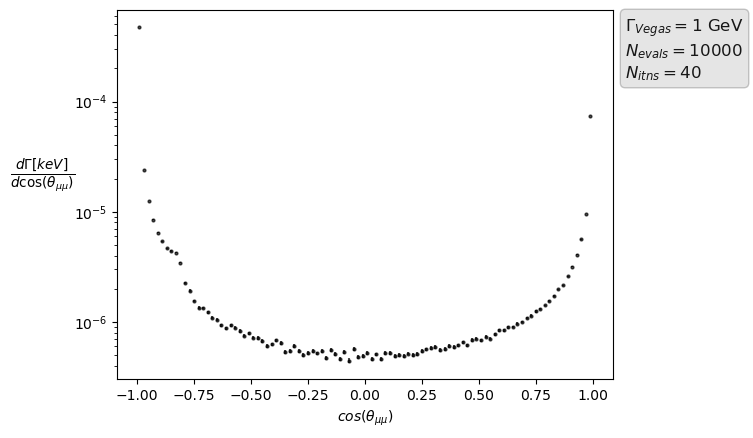

In [43]:
dI_cos8_alt = []
dI_cos8_alt_errs = []

cos_s = []
for i in range(0, bins):
    cos_s += [-1 + (i + 0.5) * 2 / bins]
    
for i in range(0, bins):
    dI_cos8_alt += [total_rate8_5['dI_8_5cos_alt'][i].mean + total_rate8_6['dI_8_6cos_alt'][i].mean + total_rate8_7['dI_8_7cos_alt'][i].mean + total_rate8_8['dI_8_8cos_alt'][i].mean+ total_rate8_9['dI_8_9cos_alt'][i].mean + total_rate8_10['dI_8_10cos_alt'][i].mean]
    dI_cos8_alt_errs += [total_rate8_5['dI_8_5cos_alt'][i].sdev + total_rate8_6['dI_8_6cos_alt'][i].sdev + total_rate8_7['dI_8_7cos_alt'][i].sdev + total_rate8_8['dI_8_8cos_alt'][i].sdev+ total_rate8_9['dI_8_9cos_alt'][i].sdev + total_rate8_10['dI_8_10cos_alt'][i].sdev]
    
norm = 2 / bins
keV = 10 ** 6

fig, ax = plt.subplots()

ax.errorbar(cos_s, keV * np.array(dI_cos8_alt) / norm, color = 'black', alpha = 0.7, 
            ls = 'None', markersize = 4, marker = '.', label = 'Vegas', yerr = keV * np.array(dI_cos8_alt_errs) / norm)

textstr = '\n'.join((
    r'$\Gamma_{Vegas}=$' +str(round(1, 11))+ ' GeV',
    r'$N_{evals}=$' +str(nevals)+ '',
    r'$N_{itns}=$' +str(nitns)+ ''))

props = dict(boxstyle='round', facecolor='gray', alpha=0.2)
ax.text(1.025, 0.98, textstr, transform=ax.transAxes, fontsize=12, alpha = 0.9,
        verticalalignment='top', bbox=props)

plt.yscale('log')
plt.ylabel(r'$\frac{d\Gamma[keV]}{d\cos(\theta_{\mu\mu})}$', rotation = '0', fontsize = 14)
ax.yaxis.set_label_coords(-0.15, 0.5)
plt.xlabel(r'$cos(\theta_{\mu\mu})$')
plt.show()

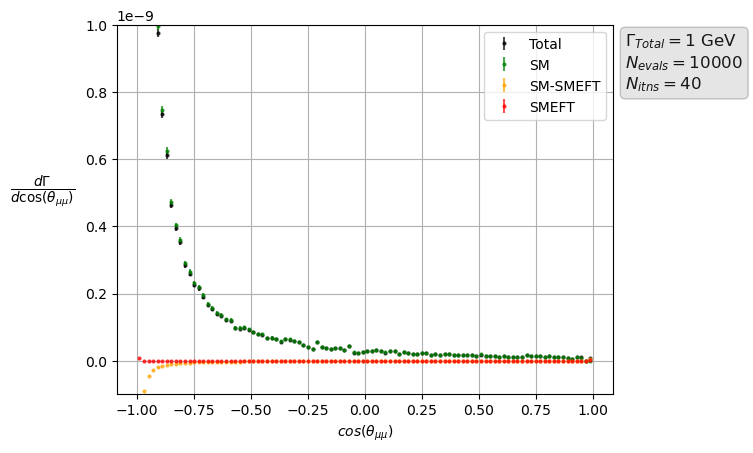

In [52]:
fig, ax = plt.subplots()

ax.errorbar(cos_s, np.array(dI_cos4_alt)+np.array(dI_cos6_alt)+np.array(dI_cos8_alt), color = 'black', alpha = 0.7, 
            ls = 'None', markersize = 4, marker = '.', label = 'Total', yerr = np.array(dI_cos4_alt_errs)+np.array(dI_cos6_alt_errs)+np.array(dI_cos8_alt_errs))
ax.errorbar(cos_s, np.array(dI_cos4_alt), color = 'green', alpha = 0.7, 
            ls = 'None', markersize = 4, marker = '.', label = 'SM', yerr = np.array(dI_cos4_alt_errs))
ax.errorbar(cos_s, np.array(dI_cos6_alt), color = 'orange', alpha = 0.7, 
            ls = 'None', markersize = 4, marker = '.', label = 'SM-SMEFT', yerr = np.array(dI_cos6_alt_errs))
ax.errorbar(cos_s, np.array(dI_cos8_alt), color = 'red', alpha = 0.7, 
            ls = 'None', markersize = 4, marker = '.', label = 'SMEFT', yerr = np.array(dI_cos8_alt_errs))

plt.grid()
textstr = '\n'.join((
    r'$\Gamma_{Total}=$' +str(round(1, 11))+ ' GeV',
    r'$N_{evals}=$' +str(nevals)+ '',
    r'$N_{itns}=$' +str(nitns)+ ''))

props = dict(boxstyle='round', facecolor='gray', alpha=0.2)
ax.text(1.025, 0.98, textstr, transform=ax.transAxes, fontsize=12, alpha = 0.9,
        verticalalignment='top', bbox=props)

#plt.yscale('log')

plt.ylabel(r'$\frac{d\Gamma}{d\cos(\theta_{\mu\mu})}$', rotation = '0', fontsize = 14)
ax.yaxis.set_label_coords(-0.15, 0.5)
plt.xlabel(r'$cos(\theta_{\mu\mu})$')
plt.ylim(-1 * 10**-10, 10**-9)
plt.legend()
#plt.xlim(0, 130)
plt.show()

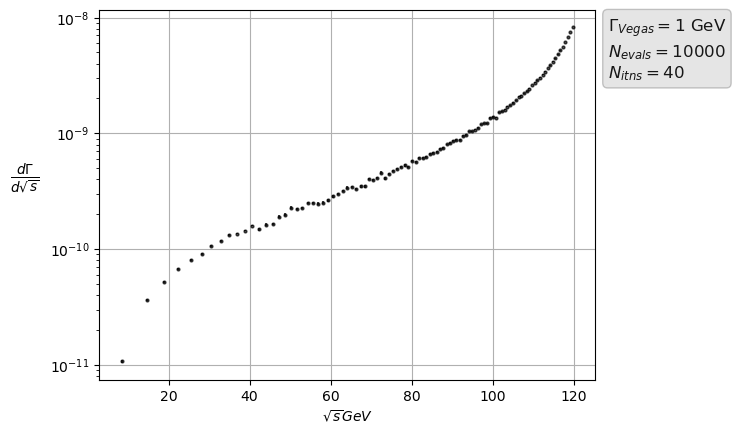

In [72]:
m = m_m
E_phot_min = 5 #GeV
s_min_fix = 4 * m ** 2 
s_max_fix = m_h ** 2 - 2 * m_h * E_phot_min
t_min_fix = t_min(s_max_fix, m)
t_max_fix = (m_h - m) ** 2

dIs = []
dI_errs = []
sqs = []
ss = []
for i in range(0, bins):
    ss += [s_min_fix + 0.5 * (s_max_fix - s_min_fix) / bins + i * (s_max_fix - s_min_fix) / bins]
    
sbins = []
for i in range(0, bins + 1):
    sbins += [i * (s_max_fix - s_min_fix) / bins]
    
sdbins = []
for i in range(0, bins):
    sdbins += [sbins[i + 1] ** 0.5 - sbins[i] ** 0.5]
    
for i in range(0, bins):
    dIs += [(total_rate4['dI_4'][i].mean + total_rate6_1['dI_6_1'][i].mean + total_rate6_2['dI_6_2'][i].mean + total_rate6_3['dI_6_3'][i].mean + total_rate6_4['dI_6_4'][i].mean+ total_rate8_5['dI_8_5'][i].mean + total_rate8_6['dI_8_6'][i].mean + total_rate8_7['dI_8_7'][i].mean + total_rate8_8['dI_8_8'][i].mean+ total_rate8_9['dI_8_9'][i].mean + total_rate8_10['dI_8_10'][i].mean) / sdbins[i]]
    dI_errs += [(total_rate4['dI_4'][i].sdev + total_rate6_1['dI_6_1'][i].sdev + total_rate6_2['dI_6_2'][i].sdev + total_rate6_3['dI_6_3'][i].sdev + total_rate6_4['dI_6_4'][i].sdev+ total_rate8_5['dI_8_5'][i].sdev + total_rate8_6['dI_8_6'][i].sdev + total_rate8_7['dI_8_7'][i].sdev + total_rate8_8['dI_8_8'][i].sdev+ total_rate8_9['dI_8_9'][i].sdev + total_rate8_10['dI_8_10'][i].sdev) / sdbins[i]]
    
sqs = np.array(ss) ** 0.5

fig, ax = plt.subplots()

ax.errorbar(sqs, np.array(dIs), color = 'black', alpha = 0.7, 
            ls = 'None', markersize = 4, marker = '.', label = 'Vegas', yerr = np.array(dI_errs))

plt.grid()
textstr = '\n'.join((
    r'$\Gamma_{Vegas}=$' +str(round(1, 11))+ ' GeV',
    r'$N_{evals}=$' +str(nevals)+ '',
    r'$N_{itns}=$' +str(nitns)+ ''))

props = dict(boxstyle='round', facecolor='gray', alpha=0.2)
ax.text(1.025, 0.98, textstr, transform=ax.transAxes, fontsize=12, alpha = 0.9,
        verticalalignment='top', bbox=props)

plt.yscale('log')

plt.ylabel(r'$\frac{d\Gamma}{d\sqrt{s}}$', rotation = '0', fontsize = 14)
ax.yaxis.set_label_coords(-0.15, 0.5)
plt.xlabel(r'$\sqrt{s} GeV$')
#plt.ylim(10**-10, 10**-6)
#plt.xlim(0, 130)
plt.show()

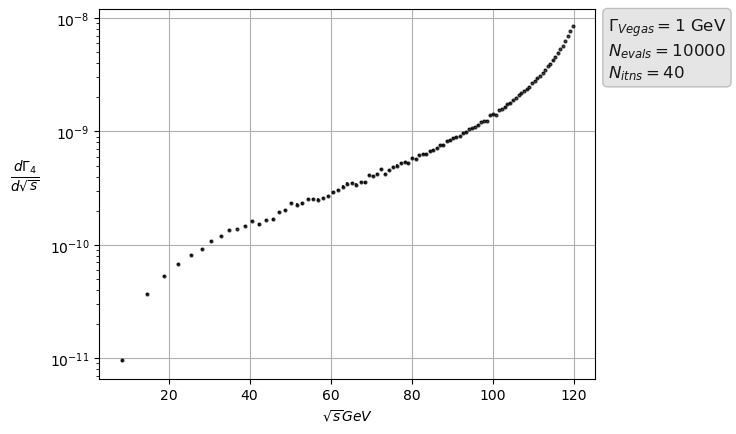

In [73]:
m = m_m
E_phot_min = 5 #GeV
s_min_fix = 4 * m ** 2 
s_max_fix = m_h ** 2 - 2 * m_h * E_phot_min
t_min_fix = t_min(s_max_fix, m)
t_max_fix = (m_h - m) ** 2

dI_4s = []
dI_4errs = []
sqs = []
ss = []
for i in range(0, bins):
    ss += [s_min_fix + 0.5 * (s_max_fix - s_min_fix) / bins + i * (s_max_fix - s_min_fix) / bins]
    
sbins = []
for i in range(0, bins + 1):
    sbins += [i * (s_max_fix - s_min_fix) / bins]
    
sdbins = []
for i in range(0, bins):
    sdbins += [sbins[i + 1] ** 0.5 - sbins[i] ** 0.5]
    
for i in range(0, bins):
    dI_4s += [(total_rate4['dI_4'][i].mean) / sdbins[i]]
    dI_4errs += [(total_rate4['dI_4'][i].sdev) / sdbins[i]]

sqs = np.array(ss) ** 0.5

fig, ax = plt.subplots()

ax.errorbar(sqs, np.array(dI_4s), color = 'black', alpha = 0.7, 
            ls = 'None', markersize = 4, marker = '.', label = 'Vegas', yerr = np.array(dI_4errs))

plt.grid()
textstr = '\n'.join((
    r'$\Gamma_{Vegas}=$' +str(round(1, 11))+ ' GeV',
    r'$N_{evals}=$' +str(nevals)+ '',
    r'$N_{itns}=$' +str(nitns)+ ''))

props = dict(boxstyle='round', facecolor='gray', alpha=0.2)
ax.text(1.025, 0.98, textstr, transform=ax.transAxes, fontsize=12, alpha = 0.9,
        verticalalignment='top', bbox=props)

plt.yscale('log')

plt.ylabel(r'$\frac{d\Gamma_{4}}{d\sqrt{s}}$', rotation = '0', fontsize = 14)
ax.yaxis.set_label_coords(-0.15, 0.5)
plt.xlabel(r'$\sqrt{s} GeV$')
#plt.ylim(10**-10, 10**-6)
#plt.xlim(0, 130)
plt.show()

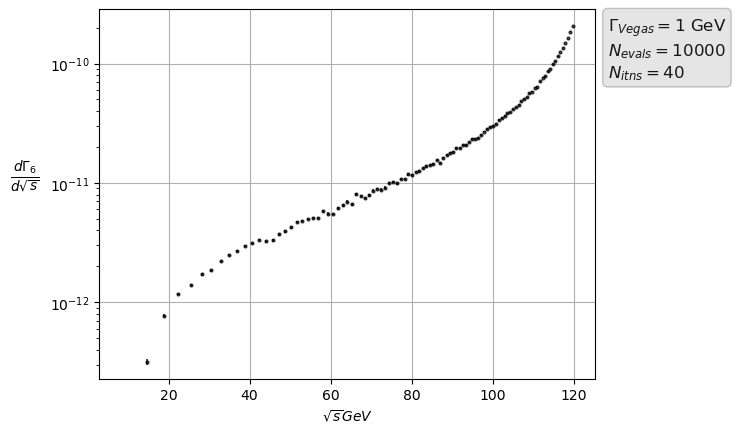

In [74]:
m = m_m
E_phot_min = 5 #GeV
s_min_fix = 4 * m ** 2 
s_max_fix = m_h ** 2 - 2 * m_h * E_phot_min
t_min_fix = t_min(s_max_fix, m)
t_max_fix = (m_h - m) ** 2

dI_6s = []
dI_6errs = []
sqs = []
ss = []
for i in range(0, bins):
    ss += [s_min_fix + 0.5 * (s_max_fix - s_min_fix) / bins + i * (s_max_fix - s_min_fix) / bins]
    
sbins = []
for i in range(0, bins + 1):
    sbins += [i * (s_max_fix - s_min_fix) / bins]
    
sdbins = []
for i in range(0, bins):
    sdbins += [sbins[i + 1] ** 0.5 - sbins[i] ** 0.5]
    
for i in range(0, bins):
    dI_6s += [(total_rate6_1['dI_6_1'][i].mean + total_rate6_2['dI_6_2'][i].mean + total_rate6_3['dI_6_3'][i].mean + total_rate6_4['dI_6_4'][i].mean) / sdbins[i]]
    dI_6errs += [(total_rate6_1['dI_6_1'][i].sdev + total_rate6_2['dI_6_2'][i].sdev + total_rate6_3['dI_6_3'][i].sdev + total_rate6_4['dI_6_4'][i].sdev) / sdbins[i]]

sqs = np.array(ss) ** 0.5

fig, ax = plt.subplots()

ax.errorbar(sqs, -np.array(dI_6s), color = 'black', alpha = 0.7, 
            ls = 'None', markersize = 4, marker = '.', label = 'Vegas', yerr = np.array(dI_6errs))

plt.grid()
textstr = '\n'.join((
    r'$\Gamma_{Vegas}=$' +str(round(1, 11))+ ' GeV',
    r'$N_{evals}=$' +str(nevals)+ '',
    r'$N_{itns}=$' +str(nitns)+ ''))

props = dict(boxstyle='round', facecolor='gray', alpha=0.2)
ax.text(1.025, 0.98, textstr, transform=ax.transAxes, fontsize=12, alpha = 0.9,
        verticalalignment='top', bbox=props)

plt.yscale('log')

plt.ylabel(r'$\frac{d\Gamma_{6}}{d\sqrt{s}}$', rotation = '0', fontsize = 14)
ax.yaxis.set_label_coords(-0.15, 0.5)
plt.xlabel(r'$\sqrt{s} GeV$')
#plt.ylim(-10**-14, 5 * 10**-13)
#plt.xlim(0, 130)
plt.show()

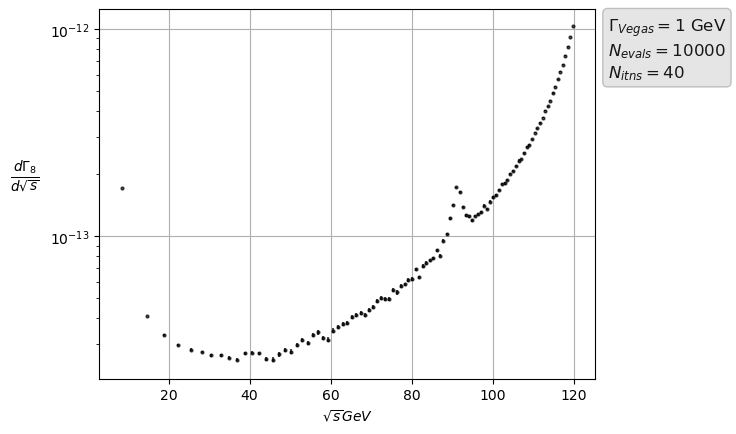

In [75]:
m = m_m
E_phot_min = 5 #GeV
s_min_fix = 4 * m ** 2 
s_max_fix = m_h ** 2 - 2 * m_h * E_phot_min
t_min_fix = t_min(s_max_fix, m)
t_max_fix = (m_h - m) ** 2

dI_8s = []
dI_8errs = []
sqs = []
ss = []
for i in range(0, bins):
    ss += [s_min_fix + 0.5 * (s_max_fix - s_min_fix) / bins + i * (s_max_fix - s_min_fix) / bins]
    
sbins = []
for i in range(0, bins + 1):
    sbins += [i * (s_max_fix - s_min_fix) / bins]
    
sdbins = []
for i in range(0, bins):
    sdbins += [sbins[i + 1] ** 0.5 - sbins[i] ** 0.5]
    
for i in range(0, bins):
    dI_8s += [(total_rate8_5['dI_8_5'][i].mean + total_rate8_6['dI_8_6'][i].mean + total_rate8_7['dI_8_7'][i].mean + total_rate8_8['dI_8_8'][i].mean+ total_rate8_9['dI_8_9'][i].mean + total_rate8_10['dI_8_10'][i].mean) / sdbins[i]]
    dI_8errs += [(total_rate8_5['dI_8_5'][i].sdev + total_rate8_6['dI_8_6'][i].sdev + total_rate8_7['dI_8_7'][i].sdev + total_rate8_8['dI_8_8'][i].sdev+ total_rate8_9['dI_8_9'][i].sdev + total_rate8_10['dI_8_10'][i].sdev) / sdbins[i]]

sqs = np.array(ss) ** 0.5

fig, ax = plt.subplots()

ax.errorbar(sqs, np.array(dI_8s), color = 'black', alpha = 0.7, 
            ls = 'None', markersize = 4, marker = '.', label = 'Vegas', yerr = np.array(dI_8errs))

plt.grid()
textstr = '\n'.join((
    r'$\Gamma_{Vegas}=$' +str(round(1, 11))+ ' GeV',
    r'$N_{evals}=$' +str(nevals)+ '',
    r'$N_{itns}=$' +str(nitns)+ ''))

props = dict(boxstyle='round', facecolor='gray', alpha=0.2)
ax.text(1.025, 0.98, textstr, transform=ax.transAxes, fontsize=12, alpha = 0.9,
        verticalalignment='top', bbox=props)

plt.yscale('log')

plt.ylabel(r'$\frac{d\Gamma_{8}}{d\sqrt{s}}$', rotation = '0', fontsize = 14)
ax.yaxis.set_label_coords(-0.15, 0.5)
plt.xlabel(r'$\sqrt{s} GeV$')
#plt.ylim(10**-10, 10**-6)
#plt.xlim(0, 130)
plt.show()

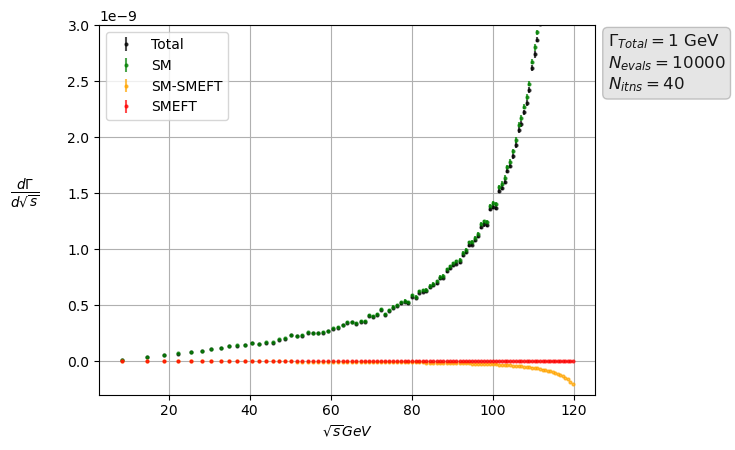

In [76]:
fig, ax = plt.subplots()

ax.errorbar(sqs, np.array(dI_4s)+np.array(dI_6s)+np.array(dI_8s), color = 'black', alpha = 0.7, 
            ls = 'None', markersize = 4, marker = '.', label = 'Total', yerr = np.array(dI_4errs)+np.array(dI_6errs)+np.array(dI_8errs))
ax.errorbar(sqs, np.array(dI_4s), color = 'green', alpha = 0.7, 
            ls = 'None', markersize = 4, marker = '.', label = 'SM', yerr = np.array(dI_4errs))
ax.errorbar(sqs, np.array(dI_6s), color = 'orange', alpha = 0.7, 
            ls = 'None', markersize = 4, marker = '.', label = 'SM-SMEFT', yerr = np.array(dI_6errs))
ax.errorbar(sqs, np.array(dI_8s), color = 'red', alpha = 0.7, 
            ls = 'None', markersize = 4, marker = '.', label = 'SMEFT', yerr = np.array(dI_8errs))

plt.grid()
textstr = '\n'.join((
    r'$\Gamma_{Total}=$' +str(round(1, 11))+ ' GeV',
    r'$N_{evals}=$' +str(nevals)+ '',
    r'$N_{itns}=$' +str(nitns)+ ''))

props = dict(boxstyle='round', facecolor='gray', alpha=0.2)
ax.text(1.025, 0.98, textstr, transform=ax.transAxes, fontsize=12, alpha = 0.9,
        verticalalignment='top', bbox=props)

#plt.yscale('log')

plt.ylabel(r'$\frac{d\Gamma}{d\sqrt{s}}$', rotation = '0', fontsize = 14)
ax.yaxis.set_label_coords(-0.15, 0.5)
plt.xlabel(r'$\sqrt{s} GeV$')
plt.ylim(-3 * 10**-10, 3 * 10**-9)
plt.legend()
#plt.xlim(0, 130)
plt.show()

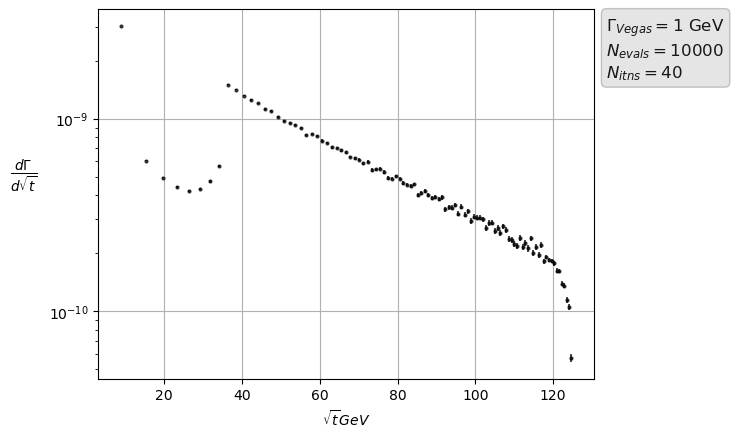

In [77]:
m = m_m
E_phot_min = 5 #GeV
s_min_fix = 4 * m ** 2 
s_max_fix = m_h ** 2 - 2 * m_h * E_phot_min
t_min_fix = t_min(s_max_fix, m)
t_max_fix = (m_h - m) ** 2

dI_ts = []
dI_terrs = []
sqt = []
ts = []
for i in range(0, bins):
    ts += [t_min_fix + 0.5 * (t_max_fix - t_min_fix) / bins + i * (t_max_fix - t_min_fix) / bins]
    
tbins = []
for i in range(0, bins + 1):
    tbins += [i * (t_max_fix - t_min_fix) / bins]
    
tdbins = []
for i in range(0, bins):
    tdbins += [tbins[i + 1] ** 0.5 - tbins[i] ** 0.5]
    
for i in range(0, bins):
    dI_ts += [(total_rate4['dI_4_t'][i].mean + total_rate6_1['dI_6_1t'][i].mean + total_rate6_2['dI_6_2t'][i].mean + total_rate6_3['dI_6_3t'][i].mean + total_rate6_4['dI_6_4t'][i].mean+ total_rate8_5['dI_8_5t'][i].mean + total_rate8_6['dI_8_6t'][i].mean + total_rate8_7['dI_8_7t'][i].mean + total_rate8_8['dI_8_8t'][i].mean+ total_rate8_9['dI_8_9t'][i].mean + total_rate8_10['dI_8_10t'][i].mean) / sdbins[i]]
    dI_terrs += [(total_rate4['dI_4_t'][i].sdev + total_rate6_1['dI_6_1t'][i].sdev + total_rate6_2['dI_6_2t'][i].sdev + total_rate6_3['dI_6_3t'][i].sdev + total_rate6_4['dI_6_4t'][i].sdev+ total_rate8_5['dI_8_5t'][i].sdev + total_rate8_6['dI_8_6t'][i].sdev + total_rate8_7['dI_8_7t'][i].sdev + total_rate8_8['dI_8_8t'][i].sdev+ total_rate8_9['dI_8_9t'][i].sdev + total_rate8_10['dI_8_10t'][i].sdev) / sdbins[i]]

sqt = np.array(ts) ** 0.5

fig, ax = plt.subplots()

ax.errorbar(sqt, np.array(dI_ts), color = 'black', alpha = 0.7, 
            ls = 'None', markersize = 4, marker = '.', label = 'Vegas', yerr = np.array(dI_terrs))

plt.grid()
textstr = '\n'.join((
    r'$\Gamma_{Vegas}=$' +str(round(1, 11))+ ' GeV',
    r'$N_{evals}=$' +str(nevals)+ '',
    r'$N_{itns}=$' +str(nitns)+ ''))

props = dict(boxstyle='round', facecolor='gray', alpha=0.2)
ax.text(1.025, 0.98, textstr, transform=ax.transAxes, fontsize=12, alpha = 0.9,
        verticalalignment='top', bbox=props)

plt.yscale('log')
plt.ylabel(r'$\frac{d\Gamma}{d\sqrt{t}}$', rotation = '0', fontsize = 14)
ax.yaxis.set_label_coords(-0.15, 0.5)
plt.xlabel(r'$\sqrt{t} GeV$')
#plt.ylim(10**-11, 10**-6)
#plt.xlim(0, 130)
plt.show()

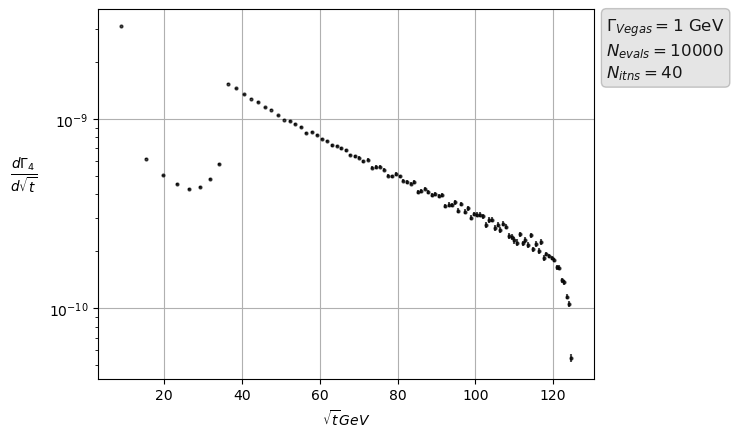

In [80]:
m = m_m
E_phot_min = 5 #GeV
s_min_fix = 4 * m ** 2 
s_max_fix = m_h ** 2 - 2 * m_h * E_phot_min
t_min_fix = t_min(s_max_fix, m)
t_max_fix = (m_h - m) ** 2

dI_4ts = []
dI_4terrs = []
sqt = []
ts = []
for i in range(0, bins):
    ts += [t_min_fix + 0.5 * (t_max_fix - t_min_fix) / bins + i * (t_max_fix - t_min_fix) / bins]
    
tbins = []
for i in range(0, bins + 1):
    tbins += [i * (t_max_fix - t_min_fix) / bins]
    
tdbins = []
for i in range(0, bins):
    tdbins += [tbins[i + 1] ** 0.5 - tbins[i] ** 0.5]
    
for i in range(0, bins):
    dI_4ts += [(total_rate4['dI_4_t'][i].mean) / sdbins[i]]
    dI_4terrs += [(total_rate4['dI_4_t'][i].sdev) / sdbins[i]]

sqt = np.array(ts) ** 0.5

fig, ax = plt.subplots()

ax.errorbar(sqt, np.array(dI_4ts), color = 'black', alpha = 0.7, 
            ls = 'None', markersize = 4, marker = '.', label = 'Vegas', yerr = np.array(dI_4terrs))

plt.grid()
textstr = '\n'.join((
    r'$\Gamma_{Vegas}=$' +str(round(1, 11))+ ' GeV',
    r'$N_{evals}=$' +str(nevals)+ '',
    r'$N_{itns}=$' +str(nitns)+ ''))

props = dict(boxstyle='round', facecolor='gray', alpha=0.2)
ax.text(1.025, 0.98, textstr, transform=ax.transAxes, fontsize=12, alpha = 0.9,
        verticalalignment='top', bbox=props)

plt.yscale('log')
plt.ylabel(r'$\frac{d\Gamma_{4}}{d\sqrt{t}}$', rotation = '0', fontsize = 14)
ax.yaxis.set_label_coords(-0.15, 0.5)
plt.xlabel(r'$\sqrt{t} GeV$')
#plt.ylim(10**-11, 10**-6)
#plt.xlim(0, 130)
plt.show()

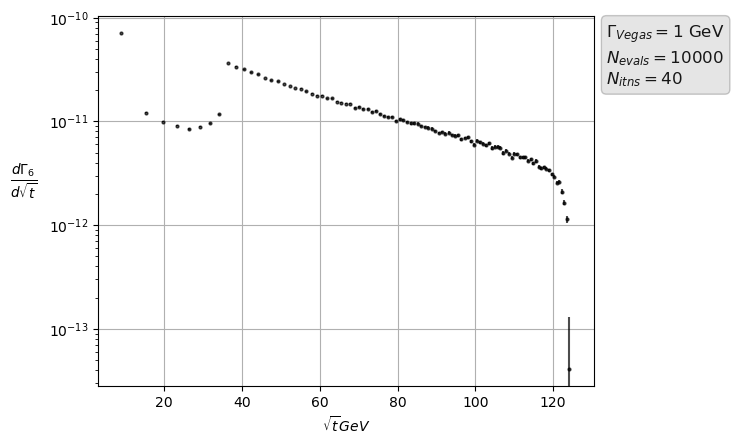

In [81]:
m = m_m
E_phot_min = 5 #GeV
s_min_fix = 4 * m ** 2 
s_max_fix = m_h ** 2 - 2 * m_h * E_phot_min
t_min_fix = t_min(s_max_fix, m)
t_max_fix = (m_h - m) ** 2

dI_6ts = []
dI_6terrs = []
sqt = []
ts = []
for i in range(0, bins):
    ts += [t_min_fix + 0.5 * (t_max_fix - t_min_fix) / bins + i * (t_max_fix - t_min_fix) / bins]
    
tbins = []
for i in range(0, bins + 1):
    tbins += [i * (t_max_fix - t_min_fix) / bins]
    
tdbins = []
for i in range(0, bins):
    tdbins += [tbins[i + 1] ** 0.5 - tbins[i] ** 0.5]
    
for i in range(0, bins):
    dI_6ts += [(total_rate6_1['dI_6_1t'][i].mean + total_rate6_2['dI_6_2t'][i].mean + total_rate6_3['dI_6_3t'][i].mean + total_rate6_4['dI_6_4t'][i].mean) / sdbins[i]]
    dI_6terrs += [(total_rate6_1['dI_6_1t'][i].sdev + total_rate6_2['dI_6_2t'][i].sdev + total_rate6_3['dI_6_3t'][i].sdev + total_rate6_4['dI_6_4t'][i].sdev) / sdbins[i]]

sqt = np.array(ts) ** 0.5

fig, ax = plt.subplots()

ax.errorbar(sqt, -np.array(dI_6ts), color = 'black', alpha = 0.7, 
            ls = 'None', markersize = 4, marker = '.', label = 'Vegas', yerr = np.array(dI_6terrs))

plt.grid()
textstr = '\n'.join((
    r'$\Gamma_{Vegas}=$' +str(round(1, 11))+ ' GeV',
    r'$N_{evals}=$' +str(nevals)+ '',
    r'$N_{itns}=$' +str(nitns)+ ''))

props = dict(boxstyle='round', facecolor='gray', alpha=0.2)
ax.text(1.025, 0.98, textstr, transform=ax.transAxes, fontsize=12, alpha = 0.9,
        verticalalignment='top', bbox=props)

plt.yscale('log')
plt.ylabel(r'$\frac{d\Gamma_{6}}{d\sqrt{t}}$', rotation = '0', fontsize = 14)
ax.yaxis.set_label_coords(-0.15, 0.5)
plt.xlabel(r'$\sqrt{t} GeV$')
#plt.ylim(10**-11, 10**-6)
#plt.xlim(0, 130)
plt.show()

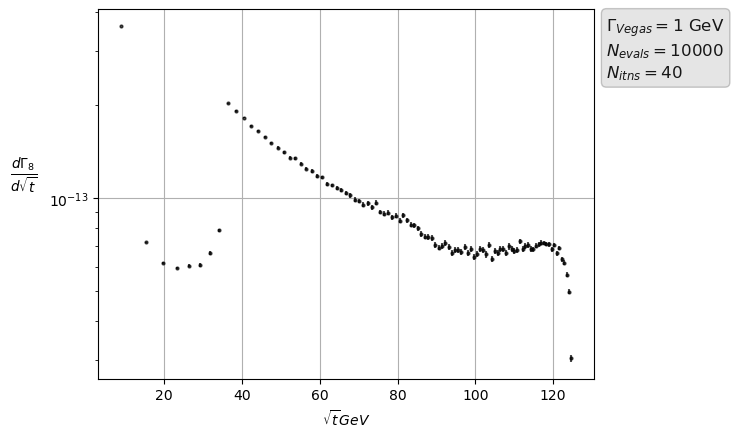

In [82]:
m = m_m
E_phot_min = 5 #GeV
s_min_fix = 4 * m ** 2 
s_max_fix = m_h ** 2 - 2 * m_h * E_phot_min
t_min_fix = t_min(s_max_fix, m)
t_max_fix = (m_h - m) ** 2

dI_8ts = []
dI_8terrs = []
sqt = []
ts = []
for i in range(0, bins):
    ts += [t_min_fix + 0.5 * (t_max_fix - t_min_fix) / bins + i * (t_max_fix - t_min_fix) / bins]
    
tbins = []
for i in range(0, bins + 1):
    tbins += [i * (t_max_fix - t_min_fix) / bins]
    
tdbins = []
for i in range(0, bins):
    tdbins += [tbins[i + 1] ** 0.5 - tbins[i] ** 0.5]
    
for i in range(0, bins):
    dI_8ts += [(total_rate8_5['dI_8_5t'][i].mean + total_rate8_6['dI_8_6t'][i].mean + total_rate8_7['dI_8_7t'][i].mean + total_rate8_8['dI_8_8t'][i].mean+ total_rate8_9['dI_8_9t'][i].mean + total_rate8_10['dI_8_10t'][i].mean) / sdbins[i]]
    dI_8terrs += [(total_rate8_5['dI_8_5t'][i].sdev + total_rate8_6['dI_8_6t'][i].sdev + total_rate8_7['dI_8_7t'][i].sdev + total_rate8_8['dI_8_8t'][i].sdev+ total_rate8_9['dI_8_9t'][i].sdev + total_rate8_10['dI_8_10t'][i].sdev) / sdbins[i]]

sqt = np.array(ts) ** 0.5

fig, ax = plt.subplots()

ax.errorbar(sqt, np.array(dI_8ts), color = 'black', alpha = 0.7, 
            ls = 'None', markersize = 4, marker = '.', label = 'Vegas', yerr = np.array(dI_8terrs))

plt.grid()
textstr = '\n'.join((
    r'$\Gamma_{Vegas}=$' +str(round(1, 11))+ ' GeV',
    r'$N_{evals}=$' +str(nevals)+ '',
    r'$N_{itns}=$' +str(nitns)+ ''))

props = dict(boxstyle='round', facecolor='gray', alpha=0.2)
ax.text(1.025, 0.98, textstr, transform=ax.transAxes, fontsize=12, alpha = 0.9,
        verticalalignment='top', bbox=props)

plt.yscale('log')
plt.ylabel(r'$\frac{d\Gamma_{8}}{d\sqrt{t}}$', rotation = '0', fontsize = 14)
ax.yaxis.set_label_coords(-0.15, 0.5)
plt.xlabel(r'$\sqrt{t} GeV$')
#plt.ylim(10**-11, 10**-6)
#plt.xlim(0, 130)
plt.show()

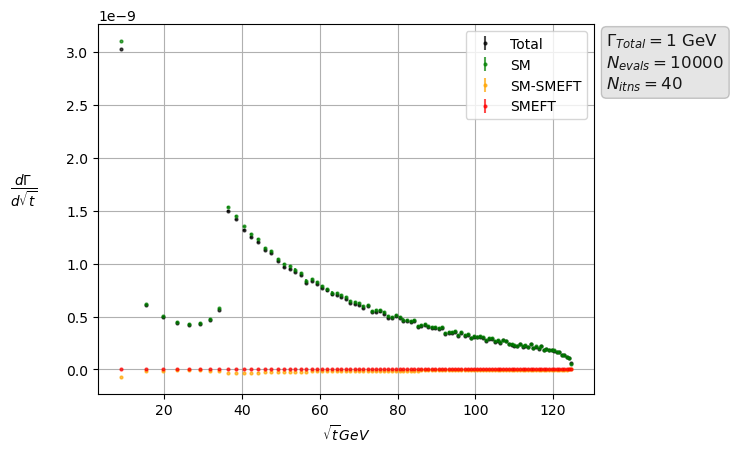

In [83]:
fig, ax = plt.subplots()

ax.errorbar(sqt, np.array(dI_4ts)+np.array(dI_6ts)+np.array(dI_8ts), color = 'black', alpha = 0.7, 
            ls = 'None', markersize = 4, marker = '.', label = 'Total', yerr = np.array(dI_4terrs)+np.array(dI_6terrs)+np.array(dI_8terrs))
ax.errorbar(sqt, np.array(dI_4ts), color = 'green', alpha = 0.7, 
            ls = 'None', markersize = 4, marker = '.', label = 'SM', yerr = np.array(dI_4terrs))
ax.errorbar(sqt, np.array(dI_6ts), color = 'orange', alpha = 0.7, 
            ls = 'None', markersize = 4, marker = '.', label = 'SM-SMEFT', yerr = np.array(dI_6terrs))
ax.errorbar(sqt, np.array(dI_8ts), color = 'red', alpha = 0.7, 
            ls = 'None', markersize = 4, marker = '.', label = 'SMEFT', yerr = np.array(dI_8terrs))

plt.grid()
textstr = '\n'.join((
    r'$\Gamma_{Total}=$' +str(round(1, 11))+ ' GeV',
    r'$N_{evals}=$' +str(nevals)+ '',
    r'$N_{itns}=$' +str(nitns)+ ''))

props = dict(boxstyle='round', facecolor='gray', alpha=0.2)
ax.text(1.025, 0.98, textstr, transform=ax.transAxes, fontsize=12, alpha = 0.9,
        verticalalignment='top', bbox=props)

#plt.yscale('log')

plt.ylabel(r'$\frac{d\Gamma}{d\sqrt{t}}$', rotation = '0', fontsize = 14)
ax.yaxis.set_label_coords(-0.15, 0.5)
plt.xlabel(r'$\sqrt{t} GeV$')
#plt.ylim(-1.6 * 10**-8, 1 * 10**-8)
plt.legend()
#plt.xlim(0, 130)
plt.show()